In [ ]:
!pip install segmentation_models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
!pip install h5py==2.10.0

!pip install opencv-python
!pip install opencv-contrib-python

!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import os
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#,force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import skimage.segmentation

In [ ]:
class OneHotDataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self,idx):
        #x = torch.tensor(self.data[idx],dtype=torch.float).permute(2,0,1).to(torch.device('cuda:0'))
        x = torch.tensor(self.data[idx],dtype=torch.float).to(torch.device('cuda:0'))
        y = torch.tensor(self.labels[idx],dtype=torch.float).to(torch.device('cuda:0'))
        return x,y


In [ ]:
folds = np.array([1,2,3,4,5,6,7])
test = 1
training = np.delete(folds,np.where(folds == test)[0])

training_imgs = []
training_labels = []
for fold in training:
  file = h5py.File(f'/content/drive/MyDrive/Thesis/Folds/Fold_{fold}_skip_50.h5','r')
  training_imgs.append(np.array(file.get('data')))
  file.close()
  training_labels.append(np.genfromtxt(f'/content/drive/MyDrive/Thesis/Folds/Labels_Fold_{fold}_skip_50.csv',delimiter=','))
training_imgs = np.concatenate(training_imgs,0)
training_labels = np.concatenate(training_labels,0)


file = h5py.File(f'/content/drive/MyDrive/Thesis/Folds/Fold_{test}_skip_50.h5','r')
val_imgs = np.array(file.get('data'))
file.close()
val_labels = np.genfromtxt(f'/content/drive/MyDrive/Thesis/Folds/Labels_Fold_{test}_skip_50.csv',delimiter=',')

BATCH_SZ = 50
X_train = training_imgs / 255
X_val = val_imgs / 255
print(np.max(X_train),np.min(X_train))
print(np.max(X_val),np.min(X_val))
# Y_train = F.one_hot(torch.tensor(training_labels,dtype=torch.int64),2)
Y_train = torch.tensor(training_labels)
# Y_val = F.one_hot(torch.tensor(val_labels,dtype=torch.int64),2)
Y_val = torch.tensor(val_labels)
print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.size()}')
print(f'X_val: {X_val.shape}')
print(f'Y_val: {Y_val.size()}')

1.0 0.0
1.0 0.0
X_train: (2066, 3, 128, 165)
Y_train: torch.Size([2066])
X_val: (430, 3, 128, 165)
Y_val: torch.Size([430])


In [ ]:
#file = h5py.File('/content/drive/MyDrive/Thesis/Data/Idx_4_14_18_20_32_skip_20.h5','r')
file = h5py.File('/content/drive/MyDrive/Thesis/IntNorm_datasets/Idx_2_3_4_5_6_skip_50.h5','r')
training_imgs = np.array(file.get('data'))
file.close()
print(f'Training imgs: {training_imgs.shape}')

#training_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Labels_Idx_4_14_18_20_32_skip_20.csv',delimiter=',')
training_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/IntNorm_datasets/Labels_Idx_2_3_4_5_6_skip_50.csv',delimiter=',')
print(f'Training Labels: {training_labels.shape}')

#file = h5py.File('/content/drive/MyDrive/Thesis/Data/Idx_1_skip_0.h5','r')
file = h5py.File('/content/drive/MyDrive/Thesis/IntNorm_datasets/Idx_1_skip_0.h5','r')
val_imgs = np.array(file.get('data'))
file.close()
print(f'Validation imgs: {val_imgs.shape}')

#val_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Labels_Idx_1_skip_0.csv',delimiter=',')
val_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/IntNorm_datasets/Labels_Idx_1_skip_0.csv',delimiter=',')
print(f'Validation Labels: {val_labels.shape}')

Training imgs: (491, 3, 128, 165)
Training Labels: (491,)
Validation imgs: (1487, 3, 128, 165)
Validation Labels: (1487,)


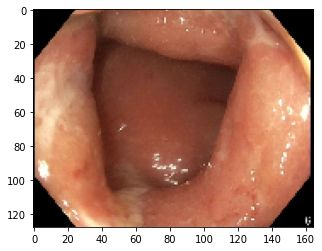

In [ ]:
plt.imshow(np.moveaxis(np.array(training_imgs[210]),[0,1,2],[2,0,1]))

In [ ]:
# Binary classification folds
kfold = KFold(n_splits=5,shuffle=True)
kfold.get_n_splits(training_imgs)
fold_idxs = list(kfold.split(training_imgs))

In [ ]:
fold = 4
BATCH_SZ = 50
X_train = training_imgs[fold_idxs[fold][0]]
X_val = val_imgs
Y_train = F.one_hot(torch.tensor(training_labels[fold_idxs[fold][0]],dtype=torch.int64),2)
Y_val = F.one_hot(torch.tensor(val_labels,dtype=torch.int64),2)
print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.size()}')
print(f'X_val: {X_val.shape}')
print(f'Y_val: {Y_val.size()}')

NameError: ignored

In [ ]:
print(torch.sum(Y_train,0),torch.sum(Y_train,0)[0]/(torch.sum(Y_train,0)[0]+torch.sum(Y_train,0)[1]),torch.sum(Y_train,0)[1]/(torch.sum(Y_train,0)[0]+torch.sum(Y_train,0)[1]))
print(torch.sum(Y_val,0),torch.sum(Y_val,0)[0]/(torch.sum(Y_val,0)[0]+torch.sum(Y_val,0)[1]),torch.sum(Y_val,0)[1]/(torch.sum(Y_val,0)[0]+torch.sum(Y_val,0)[1]))

tensor([220, 172]) tensor(0.5612) tensor(0.4388)
tensor([361, 135]) tensor(0.7278) tensor(0.2722)


In [ ]:
# Binary classification whole stack
BATCH_SZ = 50
X_train = training_imgs
X_val = val_imgs
# Y_train = torch.tensor(training_labels)
Y_train = F.one_hot(torch.tensor(training_labels,dtype=torch.int64),2)
# Y_val = torch.tensor(val_labels) 
Y_val = F.one_hot(torch.tensor(val_labels,dtype=torch.int64),2)
print(f'X_train: {X_train.shape}')
print(f'Y_train: {Y_train.size()}')
print(f'X_val: {X_val.shape}')
print(f'Y_val: {Y_val.size()}')

X_train: (491, 3, 128, 165)
Y_train: torch.Size([491, 2])
X_val: (1487, 3, 128, 165)
Y_val: torch.Size([1487, 2])


In [ ]:
# True label generation - ResNet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Treatments_All.csv',delimiter=',')
treatments = data[:,0]
frames = data[:,1]
sps = data[:,2]
val_split = 20

X_train = torch.tensor([])
for i,(frames,sp) in enumerate(zip(frames,sps),start=1):
  zeros = torch.zeros(int(sp))
  ones = torch.ones(int(frames-sp))
  labels = torch.concat((zeros,ones),0)
  idxs = torch.linspace(0,frames,1024,dtype=torch.int64)
  X_train = torch.concat((X_train,labels[idxs]),0)
X_data = torch.unsqueeze(X_train.resize(i,1024),1)
X_train = X_data[:20]
print(X_train.size())

Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
Y_train = Y_data[:20]
print(Y_train.size())

X_val = X_data[20:]
Y_val = Y_data[20:]
print(X_val.size())
print(Y_val.size())

BATCH_SZ = i

torch.Size([20, 1, 1024])
torch.Size([20, 5])
torch.Size([10, 1, 1024])
torch.Size([10, 5])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
# Predicted label generation - ResNet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
treatments = torch.tensor(data[:,0])
treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
X_data = torch.tensor([])
idx = 7

with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
  reader = csv.reader(f, delimiter=",")
  for i,line in enumerate(reader,start=1):
    pred = torch.tensor(np.array(line).astype(float))
    idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
    X_data = torch.concat((X_data,pred[idxs]),0)
X_data = torch.unsqueeze(X_data.resize(i,1000),1)
X_data = torch.cat((torch.unsqueeze(X_data[0],0),X_data[6:])) # Need to remove datasets which 2D ResNet model was trained on
print(X_data.size())
print(treatments.shape)
X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
print(X_train.size())

Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0)
print(Y_train.size())

X_val = torch.unsqueeze(X_data[idx-1],0)
Y_val = torch.unsqueeze(Y_data[idx-1],0)
print(X_val.size())
print(Y_val.size())

BATCH_SZ = i

torch.Size([25, 1, 1000])
torch.Size([25])
torch.Size([24, 1, 1000])
torch.Size([24, 5])
torch.Size([1, 1, 1000])
torch.Size([1, 5])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# True label generation - Unet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Treatments_All.csv',delimiter=',')
treatments = data[:,0]
frames = data[:,1]
sps = data[:,2]
sample_num = 1000

X_train = torch.tensor([])
for i,(frames,sp) in enumerate(zip(frames,sps),start=1):
  zeros = torch.zeros(int(sp))
  ones = torch.ones(int(frames-sp))
  labels = torch.concat((zeros,ones),0)
  idxs = torch.linspace(0,frames,sample_num,dtype=torch.int64)
  X_train = torch.concat((X_train,labels[idxs]),0)
X_data = torch.unsqueeze(X_train.resize(i,sample_num),1)
Y_data = X_data
print(X_data.size())
X_train = X_data[:20]
print(X_train.size())

Y_train = X_data[:20]
print(Y_train.size())

X_val = X_data[20:]
Y_val = X_data[20:]
print(X_val.size())
print(Y_val.size())

BATCH_SZ = 5

torch.Size([30, 1, 1000])
torch.Size([20, 1, 1000])
torch.Size([20, 1, 1000])
torch.Size([10, 1, 1000])
torch.Size([10, 1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
# Predicted label generation - Unet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
frames = data[:,1]
sps = data[:,2]
sample_num = 1000
skip = [2,3,4,5,6]
idx = 1

Y_data = torch.tensor([])
X_data = torch.tensor([])
with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
  reader = csv.reader(f, delimiter=",")
  for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
    if i in skip:
      continue
    pred = torch.tensor(np.array(line).astype(float))
    idxs = torch.linspace(0,pred.shape[0],sample_num,dtype=torch.int64)
    X_data = torch.concat((X_data,pred[idxs]),0)

    zeros = torch.zeros(int(sp))
    ones = torch.ones(int(frames-sp))
    labels = torch.concat((zeros,ones),0)
    idxs = torch.linspace(0,frames,sample_num,dtype=torch.int64)
    Y_data = torch.concat((Y_data,labels[idxs]),0)

X_data = torch.unsqueeze(X_data.resize(i-len(skip),sample_num),1)
Y_data = torch.unsqueeze(X_data.resize(i-len(skip),sample_num),1)

print(X_data.size())
print(Y_data.size())
X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
print(X_train.size())

Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0)
print(Y_train.size())

X_val = torch.unsqueeze(X_data[idx-1],0)
Y_val = torch.unsqueeze(Y_data[idx-1],0)
print(X_val.size())
print(Y_val.size())

BATCH_SZ = -len(skip)
# print(X_data.size())
# print(Y_data.size())

# X_train = X_data[:20]
# print(X_train.size())

# Y_train = Y_data[:20]
# print(Y_train.size())

# X_val = X_data[20:]
# Y_val = X_data[20:]
# print(X_val.size())
# print(Y_val.size())

# BATCH_SZ = 5

torch.Size([25, 1, 1000])
torch.Size([25, 1, 1000])
torch.Size([24, 1, 1000])
torch.Size([24, 1, 1000])
torch.Size([1, 1, 1000])
torch.Size([1, 1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
print(2 in [1,2,3])

True


In [ ]:
# Predicted and true label generation - ResNet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
treatments = torch.tensor(data[:,0])
treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
frames = data[:,1]
sps = data[:,2]
X_data = torch.tensor([])
idx = 6

with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
  reader = csv.reader(f, delimiter=",")
  for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
    pred = torch.tensor(np.array(line).astype(float))
    idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
    X_data = torch.concat((X_data,pred[idxs]),0)
  
    zeros = torch.zeros(int(sp))
    ones = torch.ones(int(frames-sp))
    labels = torch.concat((zeros,ones),0)
    idxs = torch.linspace(0,frames,1000,dtype=torch.int64)
    X_data = torch.concat((X_data,labels[idxs]),0)
    
X_data = torch.unsqueeze(X_data.resize(i*2,1000),1)
X_data = torch.cat((X_data[0:2],X_data[12:])) # Need to remove datasets which 2D ResNet model was trained on
print(X_data.size())

tmp = []
for i in range(treatments.shape[0]):
  tmp.append(treatments[i])
  tmp.append(treatments[i])
treatments = np.array(tmp)

print(treatments.shape)
X_train = torch.cat((X_data[idx:],X_data[:idx-2]),0)
# X_train = X_data[idx:]
print(X_train.size())

Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
Y_train = torch.cat((Y_data[idx:],Y_data[:idx-2]),0)
# Y_train = Y_data[idx:]
print(Y_train.size())

X_val = torch.unsqueeze(X_data[idx-2],0)
Y_val = torch.unsqueeze(Y_data[idx-2],0)
print(X_val.size())
print(Y_val.size())

BATCH_SZ = i

torch.Size([50, 1, 1000])
(50,)
torch.Size([48, 1, 1000])
torch.Size([48, 5])
torch.Size([1, 1, 1000])
torch.Size([1, 5])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
class TorchUNet(nn.Module):
    def __init__(self):
      super(TorchUNet,self).__init__()

      # Downsample
      self.b1 = nn.Sequential(
          nn.Conv1d(1,6,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(6,6,3,padding='same'),
          nn.ReLU()
      )
      self.max1 = nn.MaxPool1d(2,stride=2)

      self.b2 = nn.Sequential(
          nn.Conv1d(6,12,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(12,12,3,padding='same'),
          nn.ReLU()
      )
      self.max2 = nn.MaxPool1d(2,stride=2)

      self.b3 = nn.Sequential(
          nn.Conv1d(12,24,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(24,24,3,padding='same'),
          nn.ReLU()
      )
      self.max3 = nn.MaxPool1d(2,stride=2)

      self.b4 = nn.Sequential(
          nn.Conv1d(24,48,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(48,48,3,padding='same'),
          nn.ReLU()
      )

      
      # Upsample (upsampling as F functions in forward)
      self.upconv1 = nn.Conv1d(48,24,2,padding='same')

      self.b5 = nn.Sequential(
          nn.Conv1d(48,24,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(24,24,4,padding='same'),
          nn.ReLU()
      )

      self.upconv2 = nn.Conv1d(24,12,2,padding='same')
      self.b6 = nn.Sequential(
          nn.Conv1d(24,12,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(12,12,4,padding='same'),
          nn.ReLU()
      )

      self.upconv3 = nn.Conv1d(12,6,2,padding='same')
      self.b7 = nn.Sequential(
          nn.Conv1d(12,6,3,padding='same'),
          nn.ReLU(),
          nn.Conv1d(6,2,1,padding='same'),
          nn.ReLU()
          #nn.Softmax(dim=1)
      )

      self.headconv = nn.Conv1d(2,1,1,padding='same')

    def forward(self,x):
      # Downsample
      outb1 = self.b1(x)
      out = self.max1(outb1)
      outb2 = self.b2(out)
      out = self.max2(outb2)
      outb3 = self.b3(out)
      out = self.max3(outb3)
      outb4 = self.b4(out)
      # Upsample
      up1 = F.interpolate(outb4, scale_factor=2, mode="nearest")
      out = F.relu(self.upconv1(up1))
      out = torch.cat((out,outb3),1)
      outb5 = self.b5(out)
      up2 = F.interpolate(outb5, scale_factor=2, mode="nearest")
      out = F.relu(self.upconv2(up2))
      out = torch.cat((out,outb2),1)
      outb6 = self.b6(out)
      up3 = F.interpolate(outb6, scale_factor=2, mode="nearest")
      out = F.relu(self.upconv3(up3))
      out = torch.cat((out,outb1),1)
      outb7 = self.b7(out)
      # Head
      out = F.sigmoid(self.headconv(outb7))

      return out


In [ ]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)
        
        return out       

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)
        
        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()
        
        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)
    
    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out          

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth
        
        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)
        
        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')
        
        self.outcov = nn.Conv1d(self.layer_n, 1, kernel_size=self.kernel_size, stride=1,padding = 3)
    
        
    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)
            
    def forward(self, x):
        
        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)
        
        #############Encoder#####################
        
        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)
        
        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)
        
        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)
        
        #############Decoder####################
        
        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)
        
        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)
        
        out = self.outcov(up)
        
        out = nn.functional.sigmoid(out)
        
        return out

In [ ]:
#@title My Resnet implementation
class TorchResnet(nn.Module):
    def __init__(self):
      super(TorchResnet,self).__init__()

      self.init = nn.Sequential(
          nn.Conv1d(1,64,7,stride=1,padding=4),
          nn.MaxPool1d(9,stride=2,padding=3)
      )
      self.b1c1 = nn.Sequential(
          nn.Conv1d(64,64,9,padding='same'),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Conv1d(64,64,9,padding='same'),
          nn.BatchNorm1d(64)
      )
      self.b1c2 = nn.Sequential(
          nn.Conv1d(64,64,9,padding='same'),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv1d(64,64,9,padding='same'),
          nn.BatchNorm1d(64)
      )

      self.convBlock1 = nn.Conv1d(64,128,1,stride=2)

      self.b2c1 = nn.Sequential(
          nn.Conv1d(64,128,9,stride=2,padding=4),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Conv1d(128,128,9,padding='same'),
          nn.BatchNorm1d(128)
      )
      self.b2c2 = nn.Sequential(
          nn.Conv1d(128,128,9,padding='same'),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv1d(128,128,9,padding='same'),
          nn.BatchNorm1d(128)
      )

      self.convBlock2 = nn.Conv1d(128,256,1,stride=2)

      self.b3c1 = nn.Sequential(
          nn.Conv1d(128,256,9,stride=2,padding=4),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Conv1d(256,256,9,padding='same'),
          nn.BatchNorm1d(256)
      )
      self.b3c2 = nn.Sequential(
          nn.Conv1d(256,256,9,padding='same'),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv1d(256,256,9,padding='same'),
          nn.BatchNorm1d(256)
      )

      self.convBlock3 = nn.Conv1d(256,512,1,stride=2)

      self.b4c1 = nn.Sequential(
          nn.Conv1d(256,512,9,stride=2,padding=4),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Conv1d(512,512,9,padding='same'),
          nn.BatchNorm1d(512)
      )
      self.b4c2 = nn.Sequential(
          nn.Conv1d(512,512,9,padding='same'),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv1d(512,512,9,padding='same'),
          nn.BatchNorm1d(512)
      )
      self.avg = nn.AvgPool1d(1)
      self.flatten = nn.Flatten()
      self.dense1 = nn.Linear(32768,512) # 128: 12288, 536: 191488
      self.dropout1 = nn.Dropout(0.2)
      #self.dense2 = nn.Linear(1024,512)
      #self.dropout2 = nn.Dropout(0.3)
      self.dense3 = nn.Linear(512,128)
      self.dropout3 = nn.Dropout(0.3)
      self.dense4 = nn.Linear(128,5)
      self.dropout4 = nn.Dropout(0.3)

    def forward(self,x):
      outInit = self.init(x)
      outB1C1 = self.b1c1(outInit)
      outInt = F.relu(outB1C1 + outInit)
      outB1C2 = self.b1c2(outInt)
      outB1 = F.relu(outInt + outB1C2)

      outB2C1 = self.b2c1(outB1)
      outB2Int = F.relu(self.convBlock1(outB1) + outB2C1)
      outB2C2 = self.b2c2(outB2Int)
      outB2 = F.relu(outB2Int + outB2C2)

      outB3C1 = self.b3c1(outB2)
      outB3Int = F.relu(self.convBlock2(outB2) + outB3C1)
      outB3C2 = self.b3c2(outB3Int)
      outB3 = F.relu(outB3Int + outB3C2)

      outB4C1 = self.b4c1(outB3)
      outB4Int = F.relu(self.convBlock3(outB3) + outB4C1)
      outB4C2 = self.b4c2(outB4Int)
      outB4 = F.relu(outB4Int + outB4C2)

      out = self.avg(outB4)
      out = self.flatten(out)
      out = self.dense1(out)
      out = self.dropout1(out)
      #out = self.dense2(out)
      #out = self.dropout2(out)
      out = self.dense3(out)
      out = self.dropout3(out)
      out = self.dense4(out)
      #out = self.dropout4(out)

      return F.softmax(out)


In [ ]:
#@title My ResNet implementation
class TorchResnet(nn.Module):
    def __init__(self):
      super(TorchResnet,self).__init__()

      self.init = nn.Sequential(
          nn.Conv2d(3,64,(7,7),stride=2,padding=3),
          nn.MaxPool2d((3,3),stride=2,padding=1)
      )
      self.b1c1 = nn.Sequential(
          nn.Conv2d(64,64,(3,3),padding='same'),
          nn.ReLU(),
          nn.Conv2d(64,64,(3,3),padding='same')
      )
      self.b1c2 = nn.Sequential(
          nn.Conv2d(64,64,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(64,64,(3,3),padding='same')
      )

      self.convBlock1 = nn.Conv2d(64,128,(1,1),stride=2)

      self.b2c1 = nn.Sequential(
          nn.Conv2d(64,128,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(128,128,(3,3),padding='same')
      )
      self.b2c2 = nn.Sequential(
          nn.Conv2d(128,128,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(128,128,(3,3),padding='same')
      )

      self.convBlock2 = nn.Conv2d(128,256,(1,1),stride=2)

      self.b3c1 = nn.Sequential(
          nn.Conv2d(128,256,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,(3,3),padding='same')
      )
      self.b3c2 = nn.Sequential(
          nn.Conv2d(256,256,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(256,256,(3,3),padding='same')
      )

      self.convBlock3 = nn.Conv2d(256,512,(1,1),stride=2)

      self.b4c1 = nn.Sequential(
          nn.Conv2d(256,512,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,(3,3),padding='same')
      )
      self.b4c2 = nn.Sequential(
          nn.Conv2d(512,512,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(512,512,(3,3),padding='same')
      )
      self.avg = nn.AvgPool2d((1,1))
      self.flatten = nn.Flatten()
      self.dense1 = nn.Linear(12288,1024) # 128: 12288, 536: 191488
      self.dropout1 = nn.Dropout(0.2)
      self.dense2 = nn.Linear(1024,512)
      self.dropout2 = nn.Dropout(0.3)
      self.dense3 = nn.Linear(512,128)
      self.dropout3 = nn.Dropout(0.4)
      self.dense4 = nn.Linear(128,2)
      self.dropout4 = nn.Dropout(0.5)

    def forward(self,x):
      outInit = self.init(x)
      outB1C1 = self.b1c1(outInit)
      outInt = F.relu(outB1C1 + outInit)
      outB1C2 = self.b1c2(outInt)
      outB1 = F.relu(outInt + outB1C2)

      outB2C1 = self.b2c1(outB1)
      outB2Int = F.relu(self.convBlock1(outB1) + outB2C1)
      outB2C2 = self.b2c2(outB2Int)
      outB2 = F.relu(outB2Int + outB2C2)

      outB3C1 = self.b3c1(outB2)
      outB3Int = F.relu(self.convBlock2(outB2) + outB3C1)
      outB3C2 = self.b3c2(outB3Int)
      outB3 = F.relu(outB3Int + outB3C2)

      outB4C1 = self.b4c1(outB3)
      outB4Int = F.relu(self.convBlock3(outB3) + outB4C1)
      outB4C2 = self.b4c2(outB4Int)
      outB4 = F.relu(outB4Int + outB4C2)

      out = self.avg(outB4)
      out = self.flatten(out)
      out = self.dense1(out)
      out = self.dropout1(out)
      out = self.dense2(out)
      out = self.dropout2(out)
      out = self.dense3(out)
      out = self.dropout3(out)
      out = self.dense4(out)
      out = self.dropout4(out)

      return F.softmax(out)


In [ ]:
from typing import Type, Any, Callable, Union, List, Optional

import torch
import torch.nn as nn
from torch import Tensor

from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.utils import _log_api_usage_once


__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-f37072fd.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-b627a593.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-0676ba61.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-63fe2227.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-394f9c45.pth",
    "resnext50_32x4d": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
    "resnext101_32x8d": "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
    "wide_resnet50_2": "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
    "wide_resnet101_2": "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1024,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024,512)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(512,256)
        self.dropout3 = nn.Dropout(0.7)
        self.fc4 = nn.Linear(256,128)
        self.dropout4 = nn.Dropout(0.7)
        self.fc5 = nn.Linear(128,2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.dropout4(x)
        x = self.fc5(x)

        return F.softmax(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)

In [ ]:
from typing import Type, Any, Callable, Union, List, Optional

import torch
import torch.nn as nn
from torch import Tensor

from torchvision._internally_replaced_utils import load_state_dict_from_url
from torchvision.utils import _log_api_usage_once


__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-f37072fd.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-b627a593.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-0676ba61.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-63fe2227.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-394f9c45.pth",
    "resnext50_32x4d": "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth",
    "resnext101_32x8d": "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth",
    "wide_resnet50_2": "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth",
    "wide_resnet101_2": "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth",
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv1d:
    """3x3 convolution with padding"""
    return nn.Conv1d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv1d:
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv1d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(1000,512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512,256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256,128)
        self.dropout4 = nn.Dropout(0.6)
        self.fc5 = nn.Linear(128,1)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        #x = self.dropout2(x)
        x = self.fc3(x)
        #x = self.dropout3(x)
        x = self.fc4(x)
        #x = self.dropout4(x)
        x = self.fc5(x)

        return F.sigmoid(x)

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any,
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet181d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)

In [ ]:
# model = TorchResnet()
#model = nn.Sequential(torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),nn.Linear(1000,2),nn.Softmax()).to(torch.device('cuda:0'))
# model = resnet18()
# model = resnet181d()
model = UNET_1D(1,128,7,3)

In [ ]:
summary(model.cuda(),(1,1000))
#summary(model.cuda(),(3,128,165))
#model = nn.Sequential(torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),nn.Linear(1000,2),nn.Softmax())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool1d-1               [-1, 1, 200]               0
         AvgPool1d-2                [-1, 1, 40]               0
         AvgPool1d-3                 [-1, 1, 8]               0
            Conv1d-4            [-1, 128, 1000]           1,024
       BatchNorm1d-5            [-1, 128, 1000]             256
              ReLU-6            [-1, 128, 1000]               0
       conbr_block-7            [-1, 128, 1000]               0
            Conv1d-8            [-1, 128, 1000]         114,816
       BatchNorm1d-9            [-1, 128, 1000]             256
             ReLU-10            [-1, 128, 1000]               0
      conbr_block-11            [-1, 128, 1000]               0
           Conv1d-12            [-1, 128, 1000]         114,816
      BatchNorm1d-13            [-1, 128, 1000]             256
             ReLU-14            [-1, 12

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
torch.unsqueeze(torch.tensor(Y_train[0]),0).size()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([1, 2])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


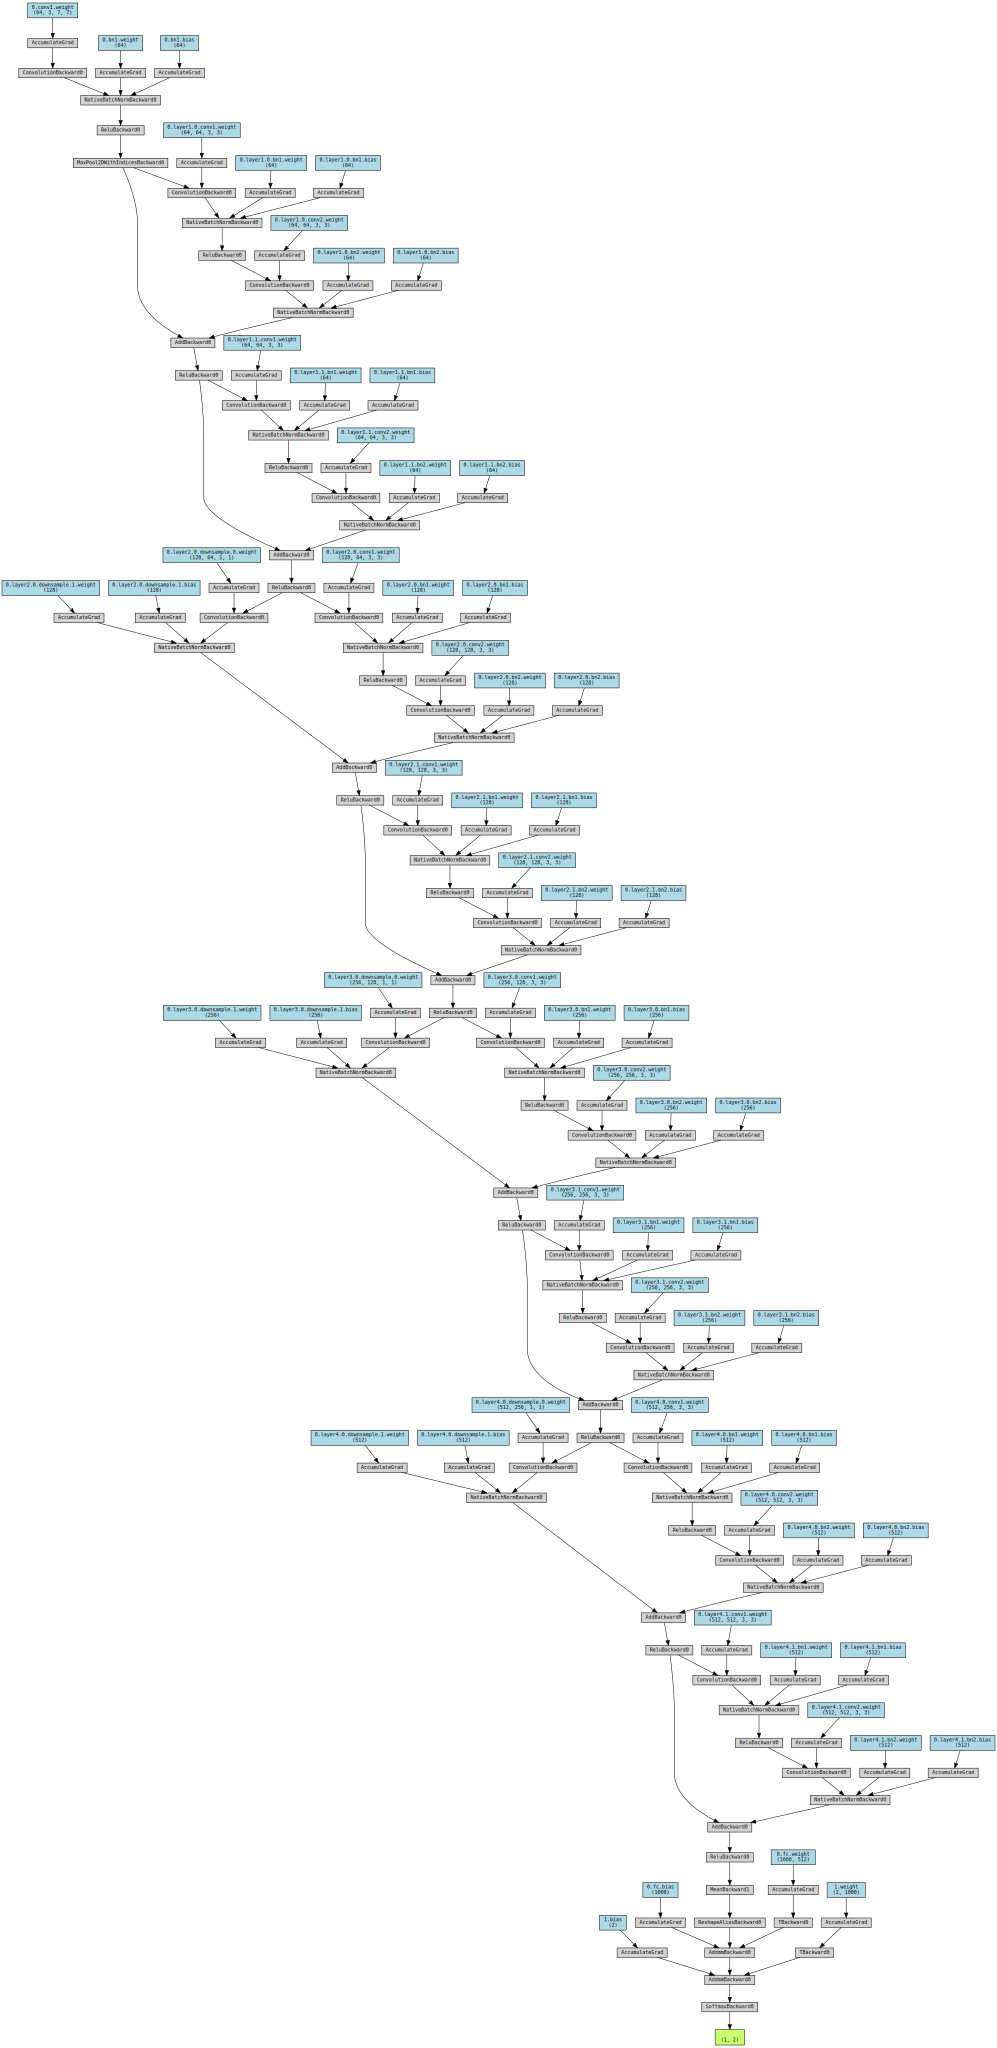

In [ ]:
#%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot
model = nn.Sequential(torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False),nn.Linear(1000,2),nn.Softmax())
x = torch.unsqueeze(torch.tensor(X_train[0],dtype=torch.float),0)
y = model(x)
make_dot(y, params=dict(model.named_parameters()))

## ResNet

In [ ]:
class_preds = []
# Predicted and true label generation - ResNet multi class
# for j in range(2,51,2):
#   data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#   treatments = torch.tensor(data[:,0])
#   treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#   frames = data[:,1]
#   sps = data[:,2]
#   X_data = torch.tensor([])
#   idx = j

#   with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
#     reader = csv.reader(f, delimiter=",")
#     for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
#       pred = torch.tensor(np.array(line).astype(float))
#       idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#       X_data = torch.concat((X_data,pred[idxs]),0)
    
#       zeros = torch.zeros(int(sp))
#       ones = torch.ones(int(frames-sp))
#       labels = torch.concat((zeros,ones),0)
#       idxs = torch.linspace(0,frames,1000,dtype=torch.int64)
#       X_data = torch.concat((X_data,labels[idxs]),0)
      
#   X_data = torch.unsqueeze(X_data.resize(i*2,1000),1)
#   X_data = torch.cat((X_data[0:2],X_data[12:])) # Need to remove datasets which 2D ResNet model was trained on
#   print(X_data.size())

#   tmp = []
#   for i in range(treatments.shape[0]):
#     tmp.append(treatments[i])
#     tmp.append(treatments[i])
#   treatments = np.array(tmp)

#   print(treatments.shape)
#   X_train = torch.cat((X_data[idx:],X_data[:idx-2]),0)
#   # X_train = X_data[idx:]
#   print(X_train.size())

#   Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#   Y_train = torch.cat((Y_data[idx:],Y_data[:idx-2]),0)
#   # Y_train = Y_data[idx:]
#   print(Y_train.size())

#   X_val = torch.unsqueeze(X_data[idx-2],0)
#   Y_val = torch.unsqueeze(Y_data[idx-2],0)
#   print(X_val.size())
#   print(Y_val.size())

# Predicted label generation - ResNet multi class
preds = []
for j in range(1,26):
  data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
  treatments = torch.tensor(data[:,0])
  treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
  X_data = torch.tensor([])
  idx = j
  skip = [2,3,4,5,6]

  with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
    reader = csv.reader(f, delimiter=",")
    for i,line in enumerate(reader,start=1):
      if i in skip:
        continue
      pred = torch.tensor(np.array(line).astype(float))
      idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
      X_data = torch.concat((X_data,pred[idxs]),0)
  X_data = torch.unsqueeze(X_data.resize(i-len(skip),1000),1)
  # X_data = torch.cat((torch.unsqueeze(X_data[0],0),X_data[6:])) # Need to remove datasets which 2D ResNet model was trained on
  print(X_data.size())
  print(treatments.shape)
  X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
  print(X_train.size())

  Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
  Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0)
  print(Y_train.size())

  X_val = torch.unsqueeze(X_data[idx-1],0)
  Y_val = torch.unsqueeze(Y_data[idx-1],0)
  print(X_val.size())
  print(Y_val.size())

# # One-vs-rest predicted
# y_true = []
# for one_vs_rest in [0,1,2,3,4]:
#   preds = []
#   for j in range(1,26):
#     data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#     treatments = torch.tensor(data[:,0])
#     treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#     X_data = torch.tensor([])
#     idx = j
#     skip = [2,3,4,5,6]

#     with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
#       reader = csv.reader(f, delimiter=",")
#       for i,line in enumerate(reader,start=1):
#         if i in skip:
#           continue
#         pred = torch.tensor(np.array(line).astype(float))
#         idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#         X_data = torch.concat((X_data,pred[idxs]),0)
#     X_data = torch.unsqueeze(X_data.resize(i-len(skip),1000),1)
#     print(X_data.size())
#     print(treatments.shape)
#     X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
#     print(X_train.size())

#     Y_vec = torch.zeros(treatments.shape[0]) # To make implementation consistent with results when adding true segmentions
#     Y_vec[treatments == one_vs_rest] = 1

#     #Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#     Y_data = torch.zeros(treatments.shape[0])
#     Y_data[treatments == one_vs_rest] = 1
#     # Y_data = torch.tensor(treatments,dtype=torch.int64)
#     Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0).view(-1,1)
#     print(Y_train.size())

#     X_val = torch.unsqueeze(X_data[idx-1],0)
#     Y_val = torch.unsqueeze(Y_data[idx-1],0).view(1,1)
#     print(X_val.size())
#     print(Y_val.size())

# # One-vs-rest predicted and True
# y_true = []
# for one_vs_rest in [0,1,2,3,4]:
#   preds = []
#   for j in range(2,51,2):
#     data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#     treatments = torch.tensor(data[:,0])
#     treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#     frames = data[:,1]
#     sps = data[:,2]
#     X_data = torch.tensor([])
#     idx = j

#     with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
#       reader = csv.reader(f, delimiter=",")
#       for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
#         pred = torch.tensor(np.array(line).astype(float))
#         idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#         X_data = torch.concat((X_data,pred[idxs]),0)
      
#         zeros = torch.zeros(int(sp))
#         ones = torch.ones(int(frames-sp))
#         labels = torch.concat((zeros,ones),0)
#         idxs = torch.linspace(0,frames,1000,dtype=torch.int64)
#         X_data = torch.concat((X_data,labels[idxs]),0)
        
#     X_data = torch.unsqueeze(X_data.resize(i*2,1000),1)
#     X_data = torch.cat((X_data[0:2],X_data[12:])) # Need to remove datasets which 2D ResNet model was trained on
#     print(X_data.size())

#     Y_vec = torch.zeros(treatments.shape[0])
#     Y_vec[treatments == one_vs_rest] = 1

#     tmp = []
#     for i in range(treatments.shape[0]):
#       tmp.append(treatments[i])
#       tmp.append(treatments[i])
#     treatments = np.array(tmp)

#     print(treatments.shape)
#     X_train = torch.cat((X_data[idx:],X_data[:idx-2]),0)
#     # X_train = X_data[idx:]
#     print(X_train.size())

#     #Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#     Y_data = torch.zeros(treatments.shape[0])
#     Y_data[treatments == one_vs_rest] = 1
#     Y_train = torch.cat((Y_data[idx:],Y_data[:idx-2]),0).view(-1,1)
#     # Y_train = Y_data[idx:]
#     print(Y_train.size())

#     X_val = torch.unsqueeze(X_data[idx-2],0)
#     Y_val = torch.unsqueeze(Y_data[idx-2],0).view(-1,1)
#     print(X_val.size())
#     print(Y_val.size())

  BATCH_SZ = 25
  model = resnet181d().to(torch.device('cuda:0'))
  train_dataloader = DataLoader(OneHotDataset(X_train,Y_train), batch_size=BATCH_SZ, shuffle=True)
  val_dataloader = DataLoader(OneHotDataset(X_val,Y_val), batch_size=BATCH_SZ, shuffle=True)
  loss_fn =  nn.CrossEntropyLoss() # nn.BCELoss() nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=0.01) #torch.optim.SGD(model.parameters(), lr=0.01)

  epochs = 120
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_dataloader, model, loss_fn, optimizer)
      test_loop(val_dataloader, model, loss_fn)
  print("Done!")

  with torch.no_grad():
    model.eval()
    pred = torch.squeeze(model(torch.unsqueeze(torch.tensor(X_val[0],dtype=torch.float32,device='cuda'),0))).detach().cpu()
    preds.append(pred)
class_preds.append(np.stack(preds,0))
#y_true.append(Y_vec.detach().cpu())

torch.Size([25, 1, 1000])
torch.Size([25])
torch.Size([24, 1, 1000])
torch.Size([24, 5])
torch.Size([1, 1, 1000])
torch.Size([1, 5])
Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ValueError: ignored

In [ ]:
class_preds = []

# # Predicted label generation - ResNet multi class
# preds = []
# for j in range(1,26):
#   data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#   treatments = torch.tensor(data[:,0])
#   treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#   X_data = torch.tensor([])
#   idx = j

#   with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_thresh_preds.csv', "r") as f:
#     reader = csv.reader(f, delimiter=",")
#     for i,line in enumerate(reader,start=1):
#       pred = torch.tensor(np.array(line).astype(float))
#       idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#       X_data = torch.concat((X_data,pred[idxs]),0)
#   X_data = torch.unsqueeze(X_data.resize(i,1000),1)
#   # X_data = torch.cat((torch.unsqueeze(X_data[0],0),X_data[6:])) # Need to remove datasets which 2D ResNet model was trained on
#   print(X_data.size())
#   print(treatments.shape)
#   X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
#   print(X_train.size())

#   Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#   Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0)
#   print(Y_train.size())

#   X_val = torch.unsqueeze(X_data[idx-1],0)
#   Y_val = torch.unsqueeze(Y_data[idx-1],0)
#   print(X_val.size())
#   print(Y_val.size())

# # Predicted and true label generation - ResNet multi class
# preds = []
# for j in range(2,51,2):
#   data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#   treatments = torch.tensor(data[:,0])
#   treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#   frames = data[:,1]
#   sps = data[:,2]
#   X_data = torch.tensor([])
#   idx = j

#   with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_thresh_preds.csv', "r") as f:
#     reader = csv.reader(f, delimiter=",")
#     for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
#       pred = torch.tensor(np.array(line).astype(float))
#       idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#       X_data = torch.concat((X_data,pred[idxs]),0)
    
#       zeros = torch.zeros(int(sp))
#       ones = torch.ones(int(frames-sp))
#       labels = torch.concat((zeros,ones),0)
#       idxs = torch.linspace(0,frames,1000,dtype=torch.int64)
#       X_data = torch.concat((X_data,labels[idxs]),0)
      
#   X_data = torch.unsqueeze(X_data.resize(i*2,1000),1)
#   #X_data = torch.cat((X_data[0:2],X_data[12:])) # Need to remove datasets which 2D ResNet model was trained on
#   print(X_data.size())

#   tmp = []
#   for i in range(treatments.shape[0]):
#     tmp.append(treatments[i])
#     tmp.append(treatments[i])
#   treatments = np.array(tmp)

#   print(treatments.shape)
#   X_train = torch.cat((X_data[idx:],X_data[:idx-2]),0)
#   # X_train = X_data[idx:]
#   print(X_train.size())

#   Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#   Y_train = torch.cat((Y_data[idx:],Y_data[:idx-2]),0)
#   # Y_train = Y_data[idx:]
#   print(Y_train.size())

#   X_val = torch.unsqueeze(X_data[idx-2],0)
#   Y_val = torch.unsqueeze(Y_data[idx-2],0)
#   print(X_val.size())
#   print(Y_val.size())


# # One-vs-rest U-Net predicted
# y_true = []
# for one_vs_rest in [0,1,2,3,4]:
#   preds = []
#   for j in range(1,26):
#     data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
#     treatments = torch.tensor(data[:,0])
#     treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
#     X_data = torch.tensor([])
#     idx = j

#     with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_thresh_preds.csv', "r") as f:
#       reader = csv.reader(f, delimiter=",")
#       for i,line in enumerate(reader,start=1):
#         pred = torch.tensor(np.array(line).astype(float))
#         idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
#         X_data = torch.concat((X_data,pred[idxs]),0)
#     X_data = torch.unsqueeze(X_data.resize(i,1000),1)
#     print(X_data.size())
#     print(treatments.shape)
#     X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
#     print(X_train.size())

#     Y_vec = torch.zeros(treatments.shape[0]) # To make implementation consistent with results when adding true segmentions
#     Y_vec[treatments == one_vs_rest] = 1

#     #Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
#     Y_data = torch.zeros(treatments.shape[0])
#     Y_data[treatments == one_vs_rest] = 1
#     # Y_data = torch.tensor(treatments,dtype=torch.int64)
#     Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0).view(-1,1)
#     print(Y_train.size())

#     X_val = torch.unsqueeze(X_data[idx-1],0)
#     Y_val = torch.unsqueeze(Y_data[idx-1],0).view(1,1)
#     print(X_val.size())
#     print(Y_val.size())

# One-vs-rest predicted and True
y_true = []
for one_vs_rest in [0,1,2,3,4]:
  preds = []
  for j in range(2,51,2):
    data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
    treatments = torch.tensor(data[:,0])
    treatments = torch.cat([treatments[0].view(1),treatments[6:]],0)
    frames = data[:,1]
    sps = data[:,2]
    X_data = torch.tensor([])
    idx = j

    with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_thresh_preds.csv', "r") as f:
      reader = csv.reader(f, delimiter=",")
      for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
        pred = torch.tensor(np.array(line).astype(float))
        idxs = torch.linspace(0,pred.shape[0],1000,dtype=torch.int64)
        X_data = torch.concat((X_data,pred[idxs]),0)
      
        zeros = torch.zeros(int(sp))
        ones = torch.ones(int(frames-sp))
        labels = torch.concat((zeros,ones),0)
        idxs = torch.linspace(0,frames,1000,dtype=torch.int64)
        X_data = torch.concat((X_data,labels[idxs]),0)
        
    X_data = torch.unsqueeze(X_data.resize(i*2,1000),1)
    #X_data = torch.cat((X_data[0:2],X_data[12:])) # Need to remove datasets which 2D ResNet model was trained on
    print(X_data.size())

    Y_vec = torch.zeros(treatments.shape[0])
    Y_vec[treatments == one_vs_rest] = 1

    tmp = []
    for i in range(treatments.shape[0]):
      tmp.append(treatments[i])
      tmp.append(treatments[i])
    treatments = np.array(tmp)

    print(treatments.shape)
    X_train = torch.cat((X_data[idx:],X_data[:idx-2]),0)
    # X_train = X_data[idx:]
    print(X_train.size())

    #Y_data = F.one_hot(torch.tensor(treatments,dtype=torch.int64),5)
    Y_data = torch.zeros(treatments.shape[0])
    Y_data[treatments == one_vs_rest] = 1
    Y_train = torch.cat((Y_data[idx:],Y_data[:idx-2]),0).view(-1,1)
    # Y_train = Y_data[idx:]
    print(Y_train.size())

    X_val = torch.unsqueeze(X_data[idx-2],0)
    Y_val = torch.unsqueeze(Y_data[idx-2],0).view(-1,1)
    print(X_val.size())
    print(Y_val.size())

    BATCH_SZ = 25
    model = resnet181d().to(torch.device('cuda:0'))
    train_dataloader = DataLoader(OneHotDataset(X_train,Y_train), batch_size=BATCH_SZ, shuffle=True)
    val_dataloader = DataLoader(OneHotDataset(X_val,Y_val), batch_size=BATCH_SZ, shuffle=True)
    loss_fn = nn.BCELoss() # nn.BCELoss() nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=0.01) #torch.optim.SGD(model.parameters(), lr=0.01)

    epochs = 70
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(val_dataloader, model, loss_fn)
    print("Done!")

    with torch.no_grad():
      model.eval()
      pred = torch.squeeze(model(torch.unsqueeze(torch.tensor(X_val[0],dtype=torch.float32,device='cuda'),0))).detach().cpu()
      preds.append(pred)
  class_preds.append(np.stack(preds,0))
  y_true.append(Y_vec.detach().cpu())

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([50, 1, 1000])
(50,)
torch.Size([48, 1, 1000])
torch.Size([48, 1])
torch.Size([1, 1, 1000])
torch.Size([1, 1])
Epoch 1
-------------------------------
loss: 0.027204  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.621175, Accuracy: 100.0%
Epoch 2
-------------------------------
loss: 0.025680  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.556910, Accuracy: 100.0%
Epoch 3
-------------------------------
loss: 0.026654  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.493436, Accuracy: 100.0%
Epoch 4
-------------------------------
loss: 0.025406  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.466362, Accuracy: 100.0%
Epoch 5
-------------------------------
loss: 0.024615  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.444385, Accuracy: 100.0%
Epoch 6
-------------------------------
loss: 0.024098  [   48/   48], Accuracy: 70.8%
Test Error: Avg loss: 0.430002, Accuracy: 100.0%
Epoch 7
-------------------------------
loss: 0.023916  [   48

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:194: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
Epoch 41
-------------------------------
loss: 0.003749  [   48/   48], Accuracy: 95.8%
Test Error: Avg loss: 0.054926, Accuracy: 100.0%
Epoch 42
-------------------------------
loss: 0.004040  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.075583, Accuracy: 100.0%
Epoch 43
-------------------------------
loss: 0.003253  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.085683, Accuracy: 100.0%
Epoch 44
-------------------------------
loss: 0.003753  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.078884, Accuracy: 100.0%
Epoch 45
-------------------------------
loss: 0.003042  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.071272, Accuracy: 100.0%
Epoch 46
-------------------------------
loss: 0.002726  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.046844, Accuracy: 100.0%
Epoch 47
-------------------------------
loss: 0.003267  [   48/   48], Accuracy: 97.9%
Test Error: Avg loss: 0.041817, Accurac

In [ ]:
# print(np.stack(class_preds,0))
print(np.argmax(np.squeeze(np.stack(class_preds,0)),1))
# print(np.round(class_preds))
# print(Y_data)

[2 2 2 2 1 1 1 2 2 2 1 1 2 2 1 2 2 2 2 2 1 0 2 1 2]


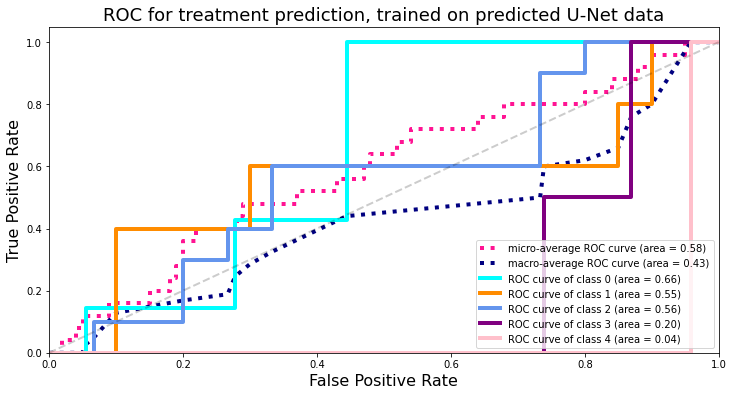

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true[i], class_preds[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12,6))
fpr["micro"], tpr["micro"], _ = roc_curve(torch.cat(y_true), np.ravel(class_preds))
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","purple","pink"])
for i, color in zip(range(5), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=4,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2,alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",size=16)
plt.ylabel("True Positive Rate",size=16)
plt.title("ROC for treatment prediction, trained on predicted U-Net data",size=18)
plt.legend(loc="lower right")
plt.show()

[0.43478261 0.40909091 0.38095238 0.4        0.42105263 0.38888889
 0.35294118 0.3125     0.33333333 0.35714286 0.30769231 0.33333333
 0.27272727 0.3        0.33333333 0.25       0.14285714 0.
 0.         0.         0.         0.         0.         1.        ]
[1.  0.9 0.8 0.8 0.8 0.7 0.6 0.5 0.5 0.5 0.4 0.4 0.3 0.3 0.3 0.2 0.1 0.
 0.  0.  0.  0.  0.  0. ]


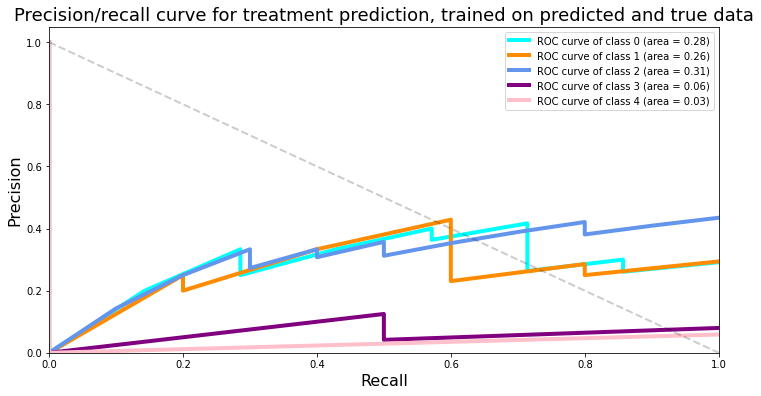

In [ ]:
from sklearn.metrics import precision_recall_curve
from itertools import cycle

recall = dict()
precision = dict()
pr_auc = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true[i], class_preds[i])
    pr_auc[i] = auc(recall[i], precision[i])
print(precision[2])
print(recall[2])

plt.figure(figsize=(12,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue","purple","pink"])
for i, color in zip(range(5), colors):
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=4,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, pr_auc[i]),
    )

plt.plot([0, 1], [1, 0], "k--", lw=2,alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall",size=16)
plt.ylabel("Precision",size=16)
plt.title("Precision/recall curve for treatment prediction, trained on predicted and true data",size=18)
plt.legend(loc="upper right")
plt.show()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_training_loss = 0
    total_correct = 0
    current = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # for name, param in model.named_parameters():
        #   print(f'{name}: {param.grad}')
        optimizer.step()

        current += len(X)
        total_training_loss += loss.item()
        total_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        # total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # total_correct += (pred.round() == y).type(torch.float).sum().item()
        correct = total_correct / current
        running_loss = total_training_loss / current

        #if batch % 2 == 0:
        print(f"\rloss: {running_loss:>7f}  [{current:>5d}/{size:>5d}], Accuracy: {(100*correct):>0.1f}%",end="")
    #print(f'\nAverage loss this epoch: {total_training_loss / num_batches:>8f}')
    # t_loss.append(running_loss)


def test_loop(dataloader, model, loss_fn):
    total_test_loss, correct = 0, 0
    current = 0
    total_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            current += len(X)
            pred = model(X)
            total_test_loss += loss_fn(pred, y).item()
            total_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            # total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # total_correct += (pred.round() == y).type(torch.float).sum().item()

    test_loss = total_test_loss/current
    correct = total_correct/current
    print(f"\nTest Error: Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}%")
    # v_loss.append(test_loss)

model = resnet18().to(torch.device('cuda:0'))
# model = resnet181d().to(torch.device('cuda:0'))
#model = TorchResnet().to(torch.device('cuda:0'))
train_dataloader = DataLoader(OneHotDataset(X_train,Y_train), batch_size=BATCH_SZ, shuffle=True)
val_dataloader = DataLoader(OneHotDataset(X_val,Y_val), batch_size=BATCH_SZ, shuffle=True)
loss_fn = nn.BCELoss() #nn.BCELoss(), nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=0) #torch.optim.SGD(model.parameters(), lr=0.01)

t_loss = []
v_loss = []

epochs = 65
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss: 0.015041  [  491/  491], Accuracy: 48.1%
Test Error: Avg loss: 0.013805, Accuracy: 72.8%
Epoch 2
-------------------------------
loss: 0.014577  [  491/  491], Accuracy: 50.7%
Test Error: Avg loss: 0.013660, Accuracy: 72.8%
Epoch 3
-------------------------------
loss: 0.014632  [  491/  491], Accuracy: 48.5%
Test Error: Avg loss: 0.013529, Accuracy: 72.8%
Epoch 4
-------------------------------
loss: 0.014664  [  491/  491], Accuracy: 51.1%
Test Error: Avg loss: 0.013389, Accuracy: 72.8%
Epoch 5
-------------------------------
loss: 0.014606  [  491/  491], Accuracy: 50.7%
Test Error: Avg loss: 0.013312, Accuracy: 72.8%
Epoch 6
-------------------------------
loss: 0.014706  [  491/  491], Accuracy: 51.9%
Test Error: Avg loss: 0.013268, Accuracy: 72.8%
Epoch 7
-------------------------------
loss: 0.014269  [  491/  491], Accuracy: 51.1%
Test Error: Avg loss: 0.013276, Accuracy: 72.9%
Epoch 8
-------------------------------
loss: 0.014785  [  491/  491], Accuracy: 50.1%
Test Err

In [ ]:
with torch.no_grad():
  model.eval()
  pred = torch.squeeze(model(torch.unsqueeze(torch.tensor(X_val[0],dtype=torch.float32,device='cuda'),0))).detach().cpu()
  pred = torch.argmax(pred)
print(pred)
print(torch.argmax(Y_val[0]))

tensor(2)
tensor(2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## UNet

In [ ]:
def DiceLoss(y,pred):
  pred = pred.round()
  intsect = torch.sum(y*pred,1)*2+1
  dice = 1 - (intsect / (torch.sum(y,1) + torch.sum(pred,1) + 1))
  return torch.mean(dice)

In [ ]:
# Predicted label generation - Unet
data = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/Treatments_All.csv',delimiter=',')
frames = data[:,1]
sps = data[:,2]
sample_num = 1000
skip = [2,3,4,5,6]
idx = 25

Y_data = torch.tensor([])
X_data = torch.tensor([])
with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', "r") as f:
  reader = csv.reader(f, delimiter=",")
  for i,(line,frames,sp) in enumerate(zip(reader,frames,sps),start=1):
    if i in skip:
      continue
    pred = torch.tensor(np.array(line).astype(float))
    idxs = torch.linspace(0,pred.shape[0],sample_num,dtype=torch.int64)
    X_data = torch.concat((X_data,pred[idxs]),0)

    zeros = torch.zeros(int(sp))
    ones = torch.ones(int(frames-sp))
    labels = torch.concat((zeros,ones),0)
    idxs = torch.linspace(0,frames,sample_num,dtype=torch.int64)
    Y_data = torch.concat((Y_data,labels[idxs]),0)

X_data = torch.unsqueeze(X_data.resize(i-len(skip),sample_num),1)
Y_data = torch.unsqueeze(Y_data.resize(i-len(skip),sample_num),1)

print(X_data.size())
print(Y_data.size())
X_train = torch.cat((X_data[idx:],X_data[:idx-1]),0)
print(X_train.size())

Y_train = torch.cat((Y_data[idx:],Y_data[:idx-1]),0)
print(Y_train.size())

X_val = torch.unsqueeze(X_data[idx-1],0)
Y_val = torch.unsqueeze(Y_data[idx-1],0)
print(X_val.size())
print(Y_val.size())


BATCH_SZ = i-len(skip)

torch.Size([25, 1, 1000])
torch.Size([25, 1, 1000])
torch.Size([24, 1, 1000])
torch.Size([24, 1, 1000])
torch.Size([1, 1, 1000])
torch.Size([1, 1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_training_loss = 0
    total_correct = 0
    current = 0
    results = torch.tensor([])
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # for name, param in model.named_parameters():
        #   print(f'{name}: {param.grad}')
        optimizer.step()

        current += len(X)
        total_training_loss += loss.item()
        results = torch.cat((results,(torch.squeeze(torch.sum(pred.round() == y,2))/1000).detach().cpu()))
        correct = torch.mean(results)
        running_loss = total_training_loss / current

        #if batch % 2 == 0:
        # print(f"\rloss: {running_loss:>7f}  [{current:>5d}/{size:>5d}], Accuracy: {(100*correct):>0.1f}%",end="")
        print(f"\rloss: {running_loss:>7f}  [{current:>5d}/{size:>5d}], Accuracy: {(100*correct):>0.1f}%",end="")
    #print(f'\nAverage loss this epoch: {total_training_loss / num_batches:>8f}')
    t_loss.append(running_loss)


def test_loop(dataloader, model, loss_fn):
    total_test_loss, correct = 0, 0
    current = 0
    total_correct = 0
    results = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            current += len(X)
            pred = model(X)
            total_test_loss += loss_fn(pred, y).item()
            results = torch.cat((results,(torch.squeeze(torch.sum(pred.round() == y,2))/1000).view(1).detach().cpu()))

    test_loss = total_test_loss/current
    correct = torch.mean(results)
    print(f"\nTest Error: Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}%")
    v_loss.append(test_loss)

model = UNET_1D(1,128,7,3).to(torch.device('cuda:0'))  #UNET_1D(1,128,7,3).to(torch.device('cuda:0')) #TorchUNet().to(torch.device('cuda:0'))
train_dataloader = DataLoader(OneHotDataset(X_train,Y_train), batch_size=BATCH_SZ, shuffle=True)
val_dataloader = DataLoader(OneHotDataset(X_val,Y_val), batch_size=BATCH_SZ, shuffle=True)
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss() #DiceLoss # nn.BCELoss() # nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-6,weight_decay=0.25) #torch.optim.SGD(model.parameters(), lr=0.01)

t_loss = []
v_loss = []

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.030685  [   24/   24], Accuracy: 45.3%
Test Error: Avg loss: 0.717171, Accuracy: 10.0%
Epoch 2
-------------------------------
loss: 0.030431  [   24/   24], Accuracy: 45.8%
Test Error: Avg loss: 0.713530, Accuracy: 10.0%
Epoch 3
-------------------------------
loss: 0.030191  [   24/   24], Accuracy: 46.3%
Test Error: Avg loss: 0.711204, Accuracy: 10.6%
Epoch 4
-------------------------------
loss: 0.029966  [   24/   24], Accuracy: 46.7%
Test Error: Avg loss: 0.707105, Accuracy: 11.4%
Epoch 5
-------------------------------
loss: 0.029751  [   24/   24], Accuracy: 47.2%
Test Error: Avg loss: 0.703979, Accuracy: 12.8%
Epoch 6
-------------------------------
loss: 0.029544  [   24/   24], Accuracy: 47.8%
Test Error: Avg loss: 0.702598, Accuracy: 13.3%
Epoch 7
-------------------------------
loss: 0.029347  [   24/   24], Accuracy: 48.4%
Test Error: Avg loss: 0.694902, Accuracy: 29.9%
Epoch 8
-------------------------------
loss: 0.029159  [   24/   24], Accuracy: 49.3%
Test Err

In [ ]:
torch.squeeze(model(torch.unsqueeze(torch.tensor(X_train[0],dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([0.645112  , 0.6451542 , 0.6451423 , ..., 0.64511704, 0.645112  ,
       0.64513016], dtype=float32)

In [ ]:
imgs,labels = list(train_dataloader)[0]
for i,l in enumerate(labels):
  print(f'{l.detach().cpu().numpy()} at idx {i}')

[0. 1.] at idx 0
[1. 0.] at idx 1
[1. 0.] at idx 2
[1. 0.] at idx 3
[1. 0.] at idx 4
[1. 0.] at idx 5
[0. 1.] at idx 6
[1. 0.] at idx 7
[1. 0.] at idx 8
[1. 0.] at idx 9
[1. 0.] at idx 10
[1. 0.] at idx 11
[1. 0.] at idx 12
[0. 1.] at idx 13
[1. 0.] at idx 14
[1. 0.] at idx 15
[1. 0.] at idx 16
[0. 1.] at idx 17
[1. 0.] at idx 18
[1. 0.] at idx 19
[0. 1.] at idx 20
[0. 1.] at idx 21
[0. 1.] at idx 22
[0. 1.] at idx 23
[1. 0.] at idx 24
[0. 1.] at idx 25
[1. 0.] at idx 26
[0. 1.] at idx 27
[0. 1.] at idx 28
[0. 1.] at idx 29
[1. 0.] at idx 30
[1. 0.] at idx 31
[0. 1.] at idx 32
[0. 1.] at idx 33
[0. 1.] at idx 34
[0. 1.] at idx 35
[1. 0.] at idx 36
[1. 0.] at idx 37
[0. 1.] at idx 38
[1. 0.] at idx 39
[1. 0.] at idx 40
[0. 1.] at idx 41
[1. 0.] at idx 42
[1. 0.] at idx 43
[0. 1.] at idx 44
[1. 0.] at idx 45
[0. 1.] at idx 46
[0. 1.] at idx 47
[1. 0.] at idx 48
[1. 0.] at idx 49


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [ ]:
file = h5py.File('/content/drive/MyDrive/Thesis/IntNorm_datasets/Idx_1_skip_0.h5','r')
data = np.array(file.get('data'))
file.close()
print(f'Validation imgs: {data.shape}')

Validation imgs: (1487, 3, 128, 165)


In [ ]:
def findThreshByScore(model,data):
  model.eval()
  with torch.no_grad():
    preds = []
    for i in range(len(data)):
        preds.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(data[i],dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
    preds = np.array(preds)
    preds = np.max(preds,1)
    # n = 2
    # for _ in range(n):
    #   tmp = []
    #   for i in range(len(data)):
    #     tmp.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(data[i],dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
    #   tmp = np.max(tmp,1)
    #   preds = np.concatenate((preds,np.array(tmp)),0)
    # print(preds.reshape(n+1,-1).shape)
    # preds = np.mean(preds.reshape(n+1,-1),0)

    
    scores = np.empty(len(preds)-1)
    for i in range(len(preds)-1):
        right = preds[i+1]
        scores[i] = preds[i]*right
    print(np.where(scores < 0.3))
    print(scores[scores < 0.3])
    print(np.min(scores),np.where(scores == np.min(scores)))
    print(np.median(np.where(scores == np.min(scores))[0]))
    print(scores[1083])


In [ ]:
findThreshByScore(model,val_imgs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(array([], dtype=int64),)
[]
0.9999996423721313 (array([0]),)
0.0
1.0


In [ ]:
def findThreshByWalker(model,data):
  model.eval()

  preds = []
  with torch.no_grad():
    for i in range(len(data)):
        preds.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(data[i],dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
  preds = np.array(preds)
  preds = np.max(preds,1)

  preds = np.concatenate((preds,preds),0).reshape(2,-1)

  labels = np.zeros(preds.shape)
  labels[0,0] = 1
  labels[1,0] = 1
  labels[0,-1] = 2
  labels[1,-1] = 2

  segs = skimage.segmentation.random_walker(preds,labels,mode='cg_j',beta=130)
  intersection = np.intersect1d(np.where(segs[0]==2)[0],np.where(segs[1]==2)[0])
  print(intersection)
  diff = []
  for i in range(len(intersection)-1):
    diff.append(abs(intersection[i]-intersection[i+1]))
  intersection[np.argmax(diff)+1]
  return intersection

In [ ]:
findThreshByWalker(model,data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433
 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447
 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461
 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475
 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486]


array([1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430,
       1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441,
       1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452,
       1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463,
       1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474,
       1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485,
       1486])

In [ ]:
idx = 1
file_name = f'Idx_{idx}_skip_0'
file = h5py.File(f'/content/drive/MyDrive/Thesis/IntNorm_datasets/{file_name}.h5','r')
#file = h5py.File(f'/content/drive/MyDrive/Thesis/SP_Datasets/{file_name}.h5','r')
data = np.array(file.get('data'))
file.close()
# data = data / 255

treatments = np.genfromtxt('/content/drive/MyDrive/Thesis/Treatment_datasets/SP_All.csv',delimiter=',')
sps = treatments[idx-1,1]

print(sps)
print(np.max(data),np.min(data))
print(f'Validation imgs: {data.shape}')

1083.0
1.0 0.0
Validation imgs: (1487, 3, 128, 165)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


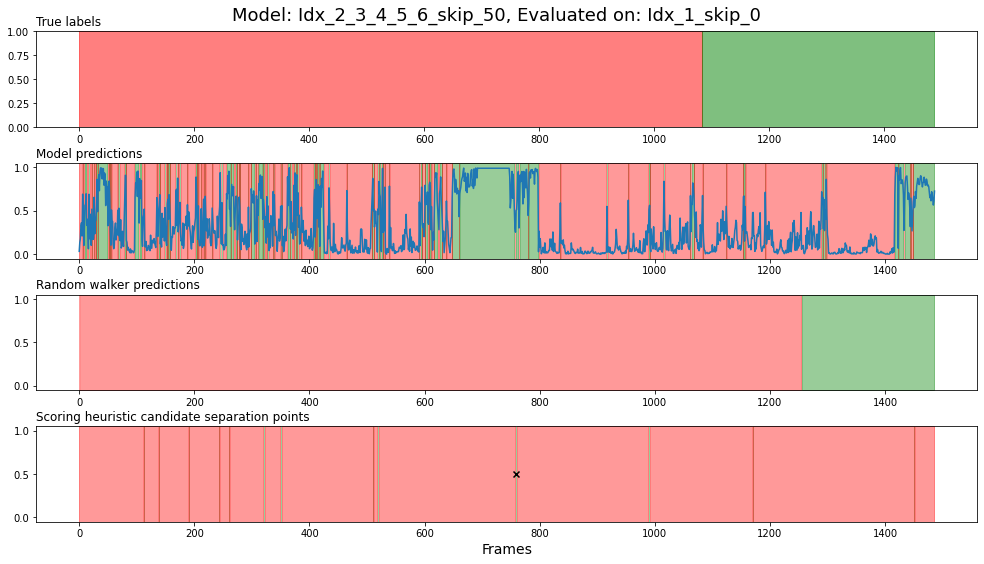

In [ ]:
from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(4,1,figsize=(14,8))
fig.tight_layout(pad=1.5,rect=[0, 0.03, 1, 0.97])
end_point = data.shape[0]
separation_point = sps
# end_point = 1487
# separation_point = 1083
x = np.arange(end_point)

# True labels
ax[0].axvspan(0, separation_point, alpha=0.5, color='red')
ax[0].axvspan(separation_point, end_point, alpha=0.5, color='green')
ax[0].set_title('True labels',loc='left')

# Model predictions
model.eval()
with torch.no_grad():
  preds = []
  for i in range(len(data)):
      preds.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(data[i],dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
  preds = np.array(preds)
  t_preds = preds[:,1]
  m_preds = np.max(preds,1)

# Model viz
thresh = np.zeros(len(x))
thresh[t_preds > 0.5] = 1
ax[1].plot(x,t_preds)
ax[1].fill_between(x, 0, 1, where=thresh, alpha=0.4, transform=ax[1].get_xaxis_transform(),color='green')
ax[1].fill_between(x, 0, 1, where=np.logical_not(thresh), alpha=0.4, transform=ax[1].get_xaxis_transform(),color='red')
ax[1].set_title('Model predictions',loc='left')

# Walker viz
w_preds = np.concatenate((m_preds,m_preds),0).reshape(2,-1)
#w_preds = np.concatenate((t_preds,t_preds),0).reshape(2,-1)
labels = np.zeros(w_preds.shape)
labels[:,0] = 1
labels[:,-1] = 2

segs = skimage.segmentation.random_walker(w_preds,labels,mode='cg_j',beta=130)
intersection = np.intersect1d(np.where(segs[0]==2)[0],np.where(segs[1]==2)[0])
idxs = np.zeros(len(x))
idxs[intersection] = 1
ax[2].fill_between(x, 0, 1, where=idxs, alpha=0.4, transform=ax[2].get_xaxis_transform(),color='green')
ax[2].fill_between(x, 0, 1, where=np.logical_not(idxs), alpha=0.4, transform=ax[2].get_xaxis_transform(),color='red')
ax[2].set_title('Random walker predictions',loc='left')

# Score candidate points
scores = np.empty(len(m_preds))
for i in range(len(m_preds)-1):
    right = m_preds[i+1]
    scores[i] = m_preds[i]*right
scores[-1] = 0.5

idxs = np.zeros(len(x))
idxs[scores < 0.3] = 1
ax[3].fill_between(x, 0, 1, where=idxs, alpha=0.4, transform=ax[3].get_xaxis_transform(),color='green')
ax[3].fill_between(x, 0, 1, where=np.logical_not(idxs), alpha=0.4, transform=ax[3].get_xaxis_transform(),color='red')
ax[3].scatter(np.median(np.where(scores == np.min(scores))[0]),0.5,marker='x',color='black')
ax[3].set_title('Scoring heuristic candidate separation points',loc='left')

fig.suptitle(f'Model: Idx_2_3_4_5_6_skip_50, Evaluated on: Idx_{idx}_skip_0',size=18)
plt.xlabel('Frames',size=14)
plt.show()

In [ ]:
9print(np.where(segs[1]==2))
print(np.median(np.where(scores == np.min(scores))[0]))
print(separation_point)

(array([3300, 3301, 3302]),)
2895.0
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


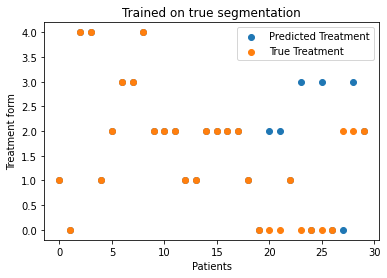

In [ ]:
model.eval()
with torch.no_grad():
  preds = []
  for data in X_data:
      preds.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(data,dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
  preds = np.argmax(np.array(preds),1)
plt.scatter(np.arange(preds.shape[0]),preds,label='Predicted Treatment')
plt.scatter(np.arange(preds.shape[0]),torch.argmax(Y_data,1),label='True Treatment')
plt.ylabel('Treatment form')
plt.xlabel('Patients')
plt.title('Trained on true segmentation')
plt.legend()

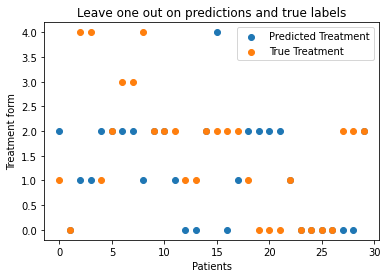

In [ ]:
preds = np.array([1,0,4,2,2,2,2,3,0,2,2,1,2,4,2,1,0,2,2,2,2,2,1,3,0,0,0,0,3,1])
plt.scatter(np.arange(preds.shape[0]),preds,label='Predicted Treatment')
plt.scatter(np.arange(preds.shape[0]),torch.argmax(Y_data,1),label='True Treatment')
plt.ylabel('Treatment form')
plt.xlabel('Patients')
plt.title('Leave one out on predictions')
plt.legend()

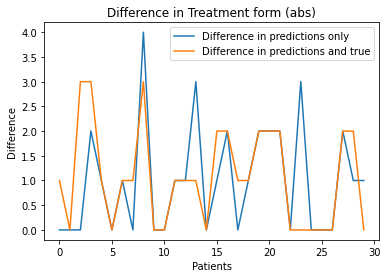

In [ ]:
preds_preds = np.array([1,0,4,2,2,2,2,3,0,2,2,1,2,4,2,1,0,2,2,2,2,2,1,3,0,0,0,0,3,1])
preds_preds_true = np.array([2,0,1,1,2,2,2,2,1,2,2,1,0,0,2,4,0,1,2,2,2,2,1,0,0,0,0,0,0,2])
labels = torch.argmax(Y_data,1).numpy()
diff_preds = np.abs(preds_preds - labels)
diff_preds_true = np.abs(preds_preds_true - labels)
plt.plot(np.arange(preds.shape[0]),diff_preds,label='Difference in predictions only')
plt.plot(np.arange(preds.shape[0]),diff_preds_true,label='Difference in predictions and true')
plt.ylabel('Difference')
plt.xlabel('Patients')
plt.title('Difference in Treatment form (abs)')
plt.legend()

2
-10


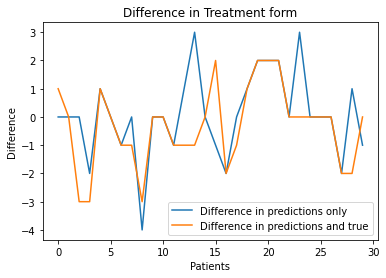

In [ ]:
preds_preds = np.array([1,0,4,2,2,2,2,3,0,2,2,1,2,4,2,1,0,2,2,2,2,2,1,3,0,0,0,0,3,1])
preds_preds_true = np.array([2,0,1,1,2,2,2,2,1,2,2,1,0,0,2,4,0,1,2,2,2,2,1,0,0,0,0,0,0,2])
labels = torch.argmax(Y_data,1).numpy()
diff_preds = preds_preds - labels
diff_preds_true = preds_preds_true - labels
print(np.sum(diff_preds))
print(np.sum(diff_preds_true))
plt.plot(np.arange(preds.shape[0]),diff_preds,label='Difference in predictions only')
plt.plot(np.arange(preds.shape[0]),diff_preds_true,label='Difference in predictions and true')
plt.ylabel('Difference')
plt.xlabel('Patients')
plt.title('Difference in Treatment form')
plt.legend()

In [ ]:
# Predict on all treatment videos
import csv

model.eval()
video_idxs = np.arange(1,31)
outer_preds = []

with open('/content/drive/MyDrive/Thesis/Treatment_datasets/TP_idx_2_3_4_5_6_skip_20.csv', 'w') as fp:
  writer = csv.writer(fp, quoting=csv.QUOTE_NONNUMERIC)
  for i in video_idxs:
    print(f'\r{i}',end='')
    file = h5py.File(f'/content/drive/MyDrive/Thesis/Treatment_datasets/Idx_{i}_skip_0.h5','r')
    data = np.array(file.get('data'))
    file.close()

    with torch.no_grad():
      preds = []
      for img in data:
          preds.append(torch.squeeze(model(torch.unsqueeze(torch.tensor(img/255,dtype=torch.float32,device='cuda'),0))).detach().cpu().numpy())
    preds = np.argmax(np.array(preds),1)
    # writer.writerow(map(lambda x: [x], list(preds)))
    writer.writerow(list(preds))
  

1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


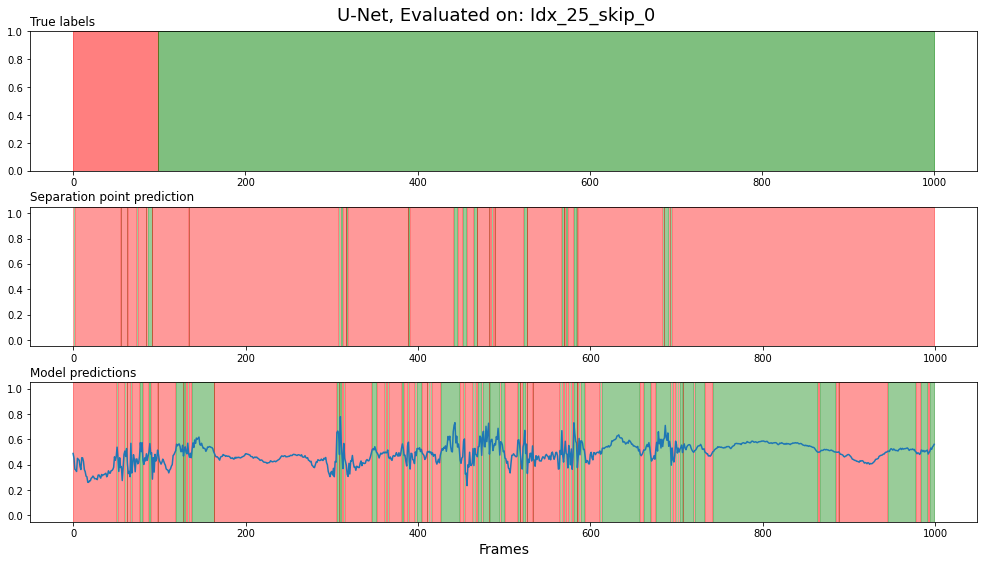

In [ ]:
from IPython.core.pylabtools import figsize
idx = idx
fig, ax = plt.subplots(3,1,figsize=(14,8))
fig.tight_layout(pad=1.5,rect=[0, 0.03, 1, 0.97])
end_point = X_val.size()[2]
separation_point = end_point - torch.sum(Y_val == 1)
x = np.arange(end_point)
file_name = f'Idx_{idx}_skip_0'

# True labels
ax[0].axvspan(0, separation_point, alpha=0.5, color='red')
ax[0].axvspan(separation_point, end_point, alpha=0.5, color='green')
ax[0].set_title('True labels',loc='left')

# 2D ResNet
thresh = np.zeros(len(x))
thresh[X_val[0,0] == 1.0] = 1
ax[1].fill_between(x, 0, 1, where=thresh, alpha=0.4, transform=ax[1].get_xaxis_transform(),color='green')
ax[1].fill_between(x, 0, 1, where=np.logical_not(thresh), alpha=0.4, transform=ax[1].get_xaxis_transform(),color='red')
ax[1].set_title('Separation point prediction',loc='left')

# Model predictions
model.eval()
with torch.no_grad():
  pred = torch.squeeze(model(torch.tensor(X_val,dtype=torch.float32,device='cuda'))).detach().cpu().numpy()
with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_prob_preds.csv', 'a') as fp:
  writer = csv.writer(fp, quoting=csv.QUOTE_NONNUMERIC)
  writer.writerow(list(pred))

# Model viz
thresh = np.zeros(len(x))
thresh[pred > 0.5] = 1

with open('/content/drive/MyDrive/Thesis/Treatment_datasets/UNet_thresh_preds.csv', 'a') as fp:
  writer = csv.writer(fp, quoting=csv.QUOTE_NONNUMERIC)
  writer.writerow(list(thresh))

ax[2].plot(x,pred)
ax[2].fill_between(x, 0, 1, where=thresh, alpha=0.4, transform=ax[2].get_xaxis_transform(),color='green')
ax[2].fill_between(x, 0, 1, where=np.logical_not(thresh), alpha=0.4, transform=ax[2].get_xaxis_transform(),color='red')
ax[2].set_title('Model predictions',loc='left')

fig.suptitle(f'U-Net, Evaluated on: {file_name}',size=18)
plt.xlabel('Frames',size=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_test = [1,3,3,4,2,2,2,1,1,2,2,2,2,1,0,0,0,1,0,0,0,0,2,2,2]
y_pred = np.argmax(np.stack(class_preds,0),1)
print(classification_report(y_test, y_pred, target_names=['Healthy','local 5-ASA','oral steroid','IV steroid','oral 5-ASA']))

              precision    recall  f1-score   support

     Healthy       0.33      0.29      0.31         7
 local 5-ASA       0.00      0.00      0.00         5
oral steroid       0.42      0.80      0.55        10
  IV steroid       0.00      0.00      0.00         2
  oral 5-ASA       0.00      0.00      0.00         1

    accuracy                           0.40        25
   macro avg       0.15      0.22      0.17        25
weighted avg       0.26      0.40      0.31        25



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import cv2
import os
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
DEVICE = 'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
vidcap = cv2.VideoCapture('/content/drive/MyDrive/Thesis/Data/Endoscopy/6286_10E20_01.E3M02')
success,image = vidcap.read()
print(success)

False


In [ ]:
count = 0
imgs = []
while success:
    image = image[:,540:,:] # Cropping
    image = cv2.resize(image,(165,128)) # cv2 uses width/height format
    imgs.append(image)
    success,image = vidcap.read()
    count += 1
imgs = np.expand_dims(np.moveaxis(np.array(imgs),[0,3,1,2],[0,1,2,3]),0)
print(imgs.shape)

AxisError: ignored

In [ ]:
count = 0
while success:
    image = image[:,540:,:] # Cropping
    image = cv2.resize(image,(536,690))
    cv2.imwrite("/content/drive/MyDrive/Thesis/Data/Frames/6286_10E20_01_frames/frame%d.jpg" % count, image)
    success,image = vidcap.read()
    count += 1
print(count)

NameError: ignored

In [ ]:
file = h5py.File('/content/drive/MyDrive/Thesis/Data/Idx_20_skip_0.h5','r')
imgs = np.expand_dims(np.array(file.get('data')),0)
file.close()
print(f'Training imgs: {imgs.shape}')

Training imgs: (1, 3303, 3, 128, 165)


In [ ]:
!pip install gym
!pip install pyglet

In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
class Logger():
  def __init__(self):
    self.persistent = []
    self.entry = []
  
  def add(self,item):
    self.entry.append(item)

  def commit(self):
    #entry = np.array(self.entry)
    self.persistent.append(self.entry)
    self.entry = []

  def stack(self):
    stack = np.array(self.persistent)
    return stack

In [ ]:
class EndoEnv():
  def __init__(self,data,actions,thresholds):
    self.action_space = actions
    self.data = data
    self.data_num = -1
    self.current_frame = 0
    self.thresholds = thresholds
    self.current_thresh = -1
    self.current_closest = -1
    self.iter = -1

  def step(self,action):
    step = (action-(self.action_space-1)//2) * 66 # 100
    if 0 <= self.current_frame + step < self.data[self.data_num].shape[0]:
      state = self.data[self.data_num,self.current_frame + step]
      self.current_frame = self.current_frame + step
    elif self.current_frame + step < 0:
      state = self.data[self.data_num,0]
      self.current_frame = 0
    else:
      state = self.data[self.data_num,-1]
      self.current_frame = self.data[self.data_num].shape[0]
    
    if action-(self.action_space-1)//2 == 0: #-2 < (action-(self.action_space-1)//2) < 2:
      done = False
    else:
      done = False
    
    # if done:
    #   val = 10*(self.current_thresh - np.abs(self.current_frame-self.current_thresh)) / self.current_thresh if (self.current_thresh - 2000 < self.current_frame < self.current_thresh + 2000) else -1#(self.current_thresh-(np.abs(self.current_frame-self.current_thresh)))
    #   reward = val# if val > -100 else -100
    # else:
    #   # current_dist = np.abs(self.current_frame - self.current_thresh)
    #   # if current_dist < self.current_closest:
    #   #   reward = 10
    #   #   self.current_closest = current_dist
    #   # else:
    #   #   reward = -10
    #   if self.iter == 99:
    #     reward = -1
    #   else:
    #     reward = 0
    #   self.iter += 1
    #   #(self.current_thresh - np.abs(self.current_frame - self.current_thresh)) / self.current_thresh * 10
    #   #print(self.current_frame,reward)

    # efficiency = (100-self.iter)/100
    # current_dist = np.abs(self.current_frame - self.current_thresh)
    # if current_dist < self.current_closest:
    #   self.current_closest = current_dist
    #   if current_dist < 400:
    #     reward = 50 * efficiency
    #   else:
    #     distance = 1-(current_dist/np.max((self.current_thresh,self.data[self.data_num].shape[0]-self.current_thresh)))**0.5
    #     reward = distance * efficiency

    # else:
    #   self.current_closest = current_dist
    #   reward = -10# * (current_dist/np.max((self.current_thresh,self.data[self.data_num].shape[0]-self.current_thresh)))**0.5
    # self.iter += 1

    # if self.iter == 49:
    #   if np.abs(self.current_frame - self.current_thresh) < 400:
    #     reward = 1
    #   else:
    #     reward = -1
    # else:
    #   reward = 0

    # self.iter += 1

    # current_dist = np.abs(self.current_frame - self.current_thresh)
    # if current_dist < 200:
    #   reward = 1
    # elif current_dist < 600:
    #   reward = 0.5
    # elif current_dist < 1200:
    #   reward = 0.1
    # else:
    #   reward = 0.001

    current_dist = np.abs(self.current_frame - self.current_thresh)
    # if current_dist < 200:
    #   reward = 1
    # elif current_dist < 400:
    #   reward = 0.9
    # elif current_dist < 600:
    #   reward = 0.8
    # elif current_dist < 800:
    #   reward = 0.7
    # elif current_dist < 1000:
    #   reward = 0.6
    # elif current_dist < 1200:
    #   reward = 0.5
    # elif current_dist < 1400:
    #   reward = 0.4
    # elif current_dist < 1600:
    #   reward = 0.3
    # elif current_dist < 1800:
    #   reward = 0.2
    # elif current_dist < 2000:
    #   reward = 0.1
    # else:
    #   reward = 0
    if current_dist < 90:
      reward = 1
    elif current_dist < 90*2:
      reward = 0.9
    elif current_dist < 90*3:
      reward = 0.8
    elif current_dist < 90*4:
      reward = 0.7
    elif current_dist < 90*5:
      reward = 0.6
    elif current_dist < 90*6:
      reward = 0.5
    elif current_dist < 90*7:
      reward = 0.4
    elif current_dist < 90*8:
      reward = 0.3
    elif current_dist < 90*9:
      reward = 0.2
    elif current_dist < 90*10:
      reward = 0.1
    else:
      reward = -0.1

    return state,reward,done # is cast to torch in env_step
  
  def reset(self):
    self.iter = 0
    self.current_closest = self.current_thresh
    self.data_num = self.data_num % self.data.shape[0]
    self.current_frame = 0#int(torch.randint(0,self.data[self.data_num].shape[0],(1,)))
    self.current_thresh = self.thresholds[self.data_num]
    return torch.tensor(self.data[self.data_num,self.current_frame],dtype=torch.float32,device=DEVICE)

In [ ]:
from torch._C import device
import collections
import gym
import numpy as np
import statistics
import torch.nn.functional as F
import tqdm

#from matplotlib import pyplot as plt
import torch.nn as nn
from typing import Any, List, Sequence, Tuple


# Create the environment
#env = gym.make("CartPole-v0")
NUM_ACTS = 3
EXPL_RATE = 1
DECAY = 0.987
#env = EndoEnv(imgs,NUM_ACTS,np.array([1026]))

# Set seed for experiment reproducibility
seed = 42
#env.seed(seed)
torch.manual_seed(0)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [ ]:
class TorchResnet(nn.Module):
    def __init__(self):
      super(TorchResnet,self).__init__()

      self.init = nn.Sequential(
          nn.Conv2d(3,64,(7,7),stride=2,padding=3),
          nn.MaxPool2d((3,3),stride=2,padding=1)
      )
      self.b1c1 = nn.Sequential(
          nn.Conv2d(64,64,(3,3),padding='same'),
          nn.ReLU(),
          nn.Conv2d(64,64,(3,3),padding='same')
      )
      self.b1c2 = nn.Sequential(
          nn.Conv2d(64,64,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(64,64,(3,3),padding='same')
      )

      self.convBlock1 = nn.Conv2d(64,128,(1,1),stride=2)

      self.b2c1 = nn.Sequential(
          nn.Conv2d(64,128,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(128,128,(3,3),padding='same')
      )
      self.b2c2 = nn.Sequential(
          nn.Conv2d(128,128,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(128,128,(3,3),padding='same')
      )

      self.convBlock2 = nn.Conv2d(128,256,(1,1),stride=2)

      self.b3c1 = nn.Sequential(
          nn.Conv2d(128,256,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(256,256,(3,3),padding='same')
      )
      self.b3c2 = nn.Sequential(
          nn.Conv2d(256,256,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(256,256,(3,3),padding='same')
      )

      self.convBlock3 = nn.Conv2d(256,512,(1,1),stride=2)

      self.b4c1 = nn.Sequential(
          nn.Conv2d(256,512,(3,3),stride=2,padding=1),
          nn.ReLU(),
          nn.Conv2d(512,512,(3,3),padding='same')
      )
      self.b4c2 = nn.Sequential(
          nn.Conv2d(512,512,(3,3),padding='same'),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Conv2d(512,512,(3,3),padding='same')
      )
      self.avg = nn.AvgPool2d((1,1))
      self.flatten = nn.Flatten()

      self.a1 = nn.Linear(12288,1024) # 128: 12288, 536: 191488
      self.a2 = nn.Linear(1024,512)
      self.a3 = nn.Linear(512,128)
      self.actor = nn.Linear(128,NUM_ACTS)

      self.c1 = nn.Linear(12288,1024) # 128: 12288, 536: 191488
      self.c2 = nn.Linear(1024,512)
      self.c3 = nn.Linear(512,128)
      self.critic = nn.Linear(128,1)

    def forward(self,x):
      outInit = self.init(x)
      outB1C1 = self.b1c1(outInit)
      outInt = F.relu(outB1C1 + outInit)
      outB1C2 = self.b1c2(outInt)
      outB1 = F.relu(outInt + outB1C2)

      outB2C1 = self.b2c1(outB1)
      outB2Int = F.relu(self.convBlock1(outB1) + outB2C1)
      outB2C2 = self.b2c2(outB2Int)
      outB2 = F.relu(outB2Int + outB2C2)

      outB3C1 = self.b3c1(outB2)
      outB3Int = F.relu(self.convBlock2(outB2) + outB3C1)
      outB3C2 = self.b3c2(outB3Int)
      outB3 = F.relu(outB3Int + outB3C2)

      outB4C1 = self.b4c1(outB3)
      outB4Int = F.relu(self.convBlock3(outB3) + outB4C1)
      outB4C2 = self.b4c2(outB4Int)
      outB4 = F.relu(outB4Int + outB4C2)

      out = self.avg(outB4)
      out = self.flatten(out)

      a = self.a1(out)
      a = self.a2(a)
      a = self.a3(a)
      actor = self.actor(a)

      c = self.c1(out)
      c = self.c2(c)
      c = self.c3(c)
      critic = self.critic(c)

      return actor,critic


In [ ]:
# class ActorCritic(nn.Module):
#   """Combined actor-critic network."""

#   def __init__(self, num_actions: int, num_hidden_units: int):
#     """Initialize."""
#     super().__init__()

#     self.common = nn.Linear(4, num_hidden_units)
#     self.actor = nn.Linear(num_hidden_units, num_actions)
#     self.critic = nn.Linear(num_hidden_units, 1)

#   def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#     x = F.relu(self.common(inputs))
#     return self.actor(x), self.critic(x)

In [ ]:
# num_actions = env.action_space.n  # 2
# num_hidden_units = 128

# model = ActorCritic(num_actions, num_hidden_units).to(torch.device('cuda:0'))

In [ ]:
def env_step(action: int) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor]:
  """Returns state, reward and done flag given an action."""

  state, reward, done = env.step(action)
  return (torch.tensor(state,dtype=torch.float32,device=DEVICE), 
          torch.tensor([reward],dtype=torch.float32,device=DEVICE),
          torch.tensor(done,device=DEVICE))

In [ ]:
def run_episode(initial_state: torch.Tensor, model: nn.Module, max_steps: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  """Runs a single episode to collect training data."""
  # action_probs = torch.zeros(max_steps,dtype=torch.float32,device=DEVICE)
  action_probs = torch.tensor([],dtype=torch.float32,device=DEVICE)
  # values = torch.zeros(max_steps,dtype=torch.float32,device=DEVICE)
  values = torch.tensor([],dtype=torch.float32,device=DEVICE)
  # rewards = torch.zeros(max_steps,dtype=torch.float32,device=DEVICE)
  rewards = torch.tensor([],dtype=torch.float32,device=DEVICE)

  initial_state_shape = initial_state.size()
  state = initial_state

  logger_actions = []
  logger_frame = []

  for t in range(max_steps):
      # Convert state into a batched tensor (batch size = 1)
      state = torch.unsqueeze(state, 0)

      # Run the model and to get action probabilities and critic value
      action_logits_t, value = model(state)

      # Sample next action from the action probability distribution
      if torch.rand(1) < EXPL_RATE:
          #action = torch.randint(NUM_ACTS,(1,))
          #dist = torch.distributions.Categorical(probs=torch.tensor([[0.12,0.12,0.12,0.12,0.005,0.005,0.005,0.12,0.12,0.12,0.12]]))
          dist = torch.distributions.Categorical(probs=torch.tensor([[0.2,0.1,0.7]]))
          #print(dist.probs)
          action = dist.sample()
          action_probs_t = F.softmax(action_logits_t)
          one = torch.zeros((NUM_ACTS,),dtype=torch.float32,device=DEVICE)
          # if 3 < action < 7 :
          #   action[0] = 7
          #   one[7] = 1.
          # else:
          one[action] = 1.
          action_probs_t = action_probs_t - action_probs_t + one
      else:
          dist = torch.distributions.Categorical(logits=action_logits_t)
          action = dist.sample()
          action_probs_t = F.softmax(action_logits_t)

      logger_actions.append(int(action[0]))

      # Store critic values
      values = torch.cat((values, torch.squeeze(value,0)))
      #values[t] = torch.squeeze(value,0)

      # Store log probability of the action chosen
      action_probs = torch.cat((action_probs, action_probs_t[0, action]))
      #action_probs[t] = action_probs_t[0, action]

      # Apply action to the environment to get next state and reward
      state, reward, done = env_step(int(action[0]))
      state = torch.tensor(state,dtype=torch.float32,device=DEVICE)
      state.view(initial_state_shape)
      logger_frame.append(env.current_frame)

      # Store reward
      rewards = torch.cat((rewards, reward))
      #rewards[t] = reward

      if done:
        break
  
  logger.add(logger_actions)
  logger.add(list(rewards.detach().cpu().numpy()))
  logger.add(logger_frame)
 
  return action_probs, values, rewards

In [ ]:
def get_expected_return(rewards: torch.Tensor, gamma: float, standardize: bool = True) -> torch.Tensor:
  """Compute expected returns per timestep."""

  n = rewards.size()[0]
  returns = torch.tensor([],device=DEVICE)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = torch.tensor(rewards.flip(0),dtype=torch.float32,device=DEVICE)
  discounted_sum = torch.tensor(0.0,device=DEVICE)
  discounted_sum_shape = discounted_sum.size()
  for i in range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    returns = torch.cat((returns, torch.unsqueeze(discounted_sum,0)))
    discounted_sum.view(discounted_sum_shape)
  returns = returns.flip(0)

  if standardize:
    if returns.size()[0] > 1:
      returns = ((returns - torch.mean(returns)) / (torch.std(returns) + eps))
    else:
      returns[0] = 0 # Single sample expectation equals sample
  return returns

In [ ]:
huber_loss = nn.HuberLoss(reduction='sum', delta=1.0)

def compute_loss(action_probs: torch.Tensor, values: torch.Tensor, returns: torch.Tensor) -> torch.Tensor:
  """Computes the combined actor-critic loss."""
  advantage = returns - values
  logger.add(returns.detach().cpu().numpy())
  logger.add(values.detach().cpu().numpy())

  action_log_probs = torch.log(action_probs)
  actor_loss = -torch.sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)
  loss_list.append(np.array([actor_loss.item(),critic_loss.item()]))
  # print(f'\n{actor_loss.item()}, {critic_loss.item()}')
  print(f'\n{advantage}')
  return actor_loss + critic_loss

In [ ]:
def train_step(initial_state: torch.Tensor, model: nn.Module, optimizer: torch.optim.Optimizer, 
               gamma: float, max_steps_per_episode: int) -> torch.Tensor:
  """Runs a model training step."""

  # Run the model for one episode to collect training data
  action_probs, values, rewards = run_episode(initial_state, model, max_steps_per_episode) 

  # Calculate expected returns
  returns = get_expected_return(rewards, gamma) 

  # Calculating loss values to update our network
  loss = compute_loss(action_probs, values, returns)
  # Compute the gradients from the loss
  optimizer.zero_grad()
  loss.backward()
  # for name, param in model.named_parameters():
  #   print(name, torch.isfinite(param.grad).all())
  # for name, param in model.named_parameters():
  #         print(f'{name}: {param.grad}')
  if torch.sum(torch.abs(model.actor.weight.grad)) < 1e-6 or torch.sum(torch.abs(model.critic.weight.grad)) < 1e-6:
    print(model.actor.weight.grad)
    print(model.critic.weight.grad)
  optimizer.step()

  episode_reward = torch.sum(rewards)

  return episode_reward

In [ ]:
%%time
min_episodes_criterion = 50
max_episodes = 600
max_steps_per_episode = 50

FRAMES = []
REWARDS = []

#env = gym.make("CartPole-v0")
#model = ActorCritic(num_actions, num_hidden_units).to(torch.device('cuda:0'))

env = EndoEnv(imgs,NUM_ACTS,np.array([1026])) #idx 4: 2681
model = TorchResnet().to(torch.device('cuda:0'))
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
logger = Logger()
EXPL_RATE = 0

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 1

# Discount factor for future rewards
gamma = 0.99
loss_list = []
# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = torch.tensor(env.reset(), dtype=torch.float32,device=DEVICE)
    episode_reward = float(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))
    FRAMES.append(env.current_frame)
    
    logger.commit()
    #EXPL_RATE = EXPL_RATE * DECAY if EXPL_RATE > 0.01 else 0.01
    if i < 100:
      EXPL_RATE = 0.6
    elif i < 150:
      EXPL_RATE = 0.5
    elif i < 200:
      EXPL_RATE = 0.4
    elif i < 250:
      EXPL_RATE = 0.3
    elif i < 300:
      EXPL_RATE = 0.2
    elif i < 350:
      EXPL_RATE = 0.1
    else:
      EXPL_RATE = 0
    
    episodes_reward.append(episode_reward)
    REWARDS.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(episode_reward=episode_reward, running_reward=running_reward)
  
    # if running_reward > reward_threshold and i >= min_episodes_criterion:  
    #     break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe


tensor([ 0.2799,  0.3646,  0.4502,  0.5361,  0.6235,  0.7119,  0.8001,  0.8904,
         0.9813,  2.1712,  2.6985,  2.6057,  2.5380,  2.0971,  2.1523,  2.1311,
         2.3745,  2.9675,  2.3452,  2.7930,  2.2930,  2.7045,  2.1852,  2.2780,
         2.0363,  2.0254,  1.9255,  1.5068,  1.2912,  1.0091,  0.8359,  0.7357,
         0.7781,  0.3274,  0.1493,  0.0205, -0.1346,  0.3436, -0.2272, -1.2300,
        -0.0349,  0.4065, -0.1537,  0.3332,  0.3298, -0.1703, -0.2045,  0.3119,
        -0.0996, -1.1058], device='cuda:0', grad_fn=<SubBackward0>)


Episode 0:   0%|          | 1/600 [00:01<14:12,  1.42s/it, episode_reward=2.6, running_reward=2.6]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



tensor([   -2.5269, -1021.6623, -1143.1395,  -947.9332,  -815.0916, -1063.6226,
         -813.2028,  -955.4319,  -805.6436, -1080.4690, -1007.7775,  -766.0650,
         -928.2202, -1014.2969, -1140.1123, -1000.7571, -1136.4086,  -935.2534,
        -1134.3068,  -941.9664, -1124.8810,  -940.6051, -1011.4952, -1053.3536,
        -1119.4663, -1053.6896, -1118.3969, -1095.0170, -1119.3634,  -863.6246,
         -923.9222,  -926.3815,  -934.4470,  -971.4893,  -960.1940, -1131.4817,
        -1092.5955, -1067.7528,  -986.7084,  -906.5798,  -961.4419,  -877.7078,
         -932.1853,  -904.5071,  -925.7415,  -900.4351,  -933.8759,  -936.0450,
         -904.1659, -1070.3372], device='cuda:0', grad_fn=<SubBackward0>)


Episode 1:   0%|          | 2/600 [00:02<12:09,  1.22s/it, episode_reward=20.7, running_reward=11.7]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 

Episode 2:   0%|          | 3/600 [00:03<11:06,  1.12s/it, episode_reward=17.8, running_reward=13.7]


tensor([1.7525, 1.7874, 1.8312, 6.6826, 8.0389, 6.9538, 8.1691, 6.8359, 6.1282,
        9.5166, 7.5537, 7.5847, 7.7232, 7.2744, 7.2766, 9.4172, 7.1134, 7.4691,
        7.2170, 7.4289, 7.2321, 5.7486, 7.7877, 7.0832, 7.5675, 8.8119, 9.1505,
        8.5906, 8.0851, 8.6717, 8.6160, 6.1138, 6.3416, 5.3544, 6.3618, 4.5397,
        5.4255, 3.5267, 4.4290, 6.2477, 5.3961, 6.4599, 6.4528, 5.1239, 5.9308,
        4.7961, 4.7700, 4.1844, 5.3328, 4.2434], device='cuda:0',
       grad_fn=<SubBackward0>)


Episode 3:   1%|          | 4/600 [00:04<11:11,  1.13s/it, episode_reward=17.8, running_reward=14.7]


tensor([ 1.3669,  2.1156,  2.2036,  1.8456,  1.8940,  1.9837,  2.4807,  2.0887,
         2.1337,  2.0182,  2.5503,  2.3903,  1.9435,  2.3297,  1.9497,  1.9864,
         1.9210,  1.9659,  2.0192,  1.8310,  1.6890,  1.7591,  1.8760,  1.5143,
         1.6508,  1.8704,  1.4492,  1.8314,  1.9063,  1.4984,  1.5326,  1.4717,
         1.2527,  1.0870,  1.1211,  1.1840,  0.3339,  0.1792,  0.0765, -0.2166,
         0.0348, -0.4960, -0.4992, -0.6665, -0.4894, -0.7943, -0.8550, -0.5924,
        -0.3518, -0.4092], device='cuda:0', grad_fn=<SubBackward0>)


Episode 4:   1%|          | 5/600 [00:05<09:10,  1.08it/s, episode_reward=24, running_reward=16.6]


tensor([ 0.8076,  0.9184,  0.8935,  1.0014,  1.0093,  1.0553,  1.0765,  1.0842,
         1.0766,  1.0656,  1.0712,  1.0757,  1.0825,  1.0981,  1.1051,  1.1105,
         1.1256,  1.1018,  1.0703,  0.9916,  0.9566,  0.9169,  0.8838,  0.8850,
         0.7956,  0.7228,  0.6938,  0.5299,  0.4004,  0.2876,  0.1778,  0.0523,
        -0.0714, -0.2213, -0.3369, -0.4722, -0.5989, -0.7317, -0.8338, -0.9638,
        -1.0663, -1.1570, -1.2408, -1.3462, -1.3804, -1.4381, -1.5138, -1.5726,
        -1.6431, -1.6972], device='cuda:0', grad_fn=<SubBackward0>)


Episode 5:   1%|          | 6/600 [00:05<07:58,  1.24it/s, episode_reward=24, running_reward=17.8]


tensor([ 0.8314,  0.4587,  0.4662,  0.5142,  0.4863,  0.5369,  0.7103,  0.5466,
         0.7145,  0.7076,  0.5275,  0.6848,  0.5201,  0.4839,  0.5427,  0.5139,
         0.5677,  0.7362,  0.5469,  0.4989,  0.6634,  0.4335,  0.3217,  0.1993,
         0.2918,  0.0296,  0.0203, -0.1019, -0.0218, -0.2731, -0.2751, -0.4342,
        -0.5262, -0.6942, -0.8477, -1.0489, -1.1600, -1.3332, -1.2950, -1.4006,
        -1.5404, -1.6528, -1.7747, -1.8450, -1.8958, -1.9707, -2.0196, -2.0544,
        -2.1076, -2.0864], device='cuda:0', grad_fn=<SubBackward0>)


Episode 6:   1%|          | 7/600 [00:06<07:13,  1.37it/s, episode_reward=22, running_reward=18.4]


tensor([ 1.1367e+00,  1.1777e+00,  1.2187e+00,  1.1078e-01,  1.2479e-01,
         2.3700e-01,  5.9667e-01,  2.8985e-01,  1.8051e-01,  6.8712e-01,
         2.1103e-01,  1.3913e-02, -6.3633e-02, -2.3221e-01,  6.6422e-02,
        -1.0073e-03, -3.1828e-01, -1.4940e-01, -4.7431e-01, -2.1227e-01,
        -4.0997e-01, -5.6454e-01, -8.3312e-01, -8.5892e-01, -1.0686e+00,
        -7.5699e-01, -8.9475e-01, -1.0973e+00, -1.0406e+00, -1.0788e+00,
        -1.1761e+00, -1.3165e+00, -1.4006e+00, -1.5996e+00, -1.6770e+00,
        -1.7380e+00, -1.9709e+00, -2.0216e+00, -2.0772e+00, -2.1063e+00,
        -2.1660e+00, -2.2068e+00, -2.2708e+00, -2.2355e+00, -2.3479e+00,
        -2.3303e+00, -2.4529e+00, -2.4120e+00, -2.5228e+00, -2.5818e+00],
       device='cuda:0', grad_fn=<SubBackward0>)


Episode 7:   1%|▏         | 8/600 [00:06<06:44,  1.46it/s, episode_reward=26.1, running_reward=19.4]


tensor([ 0.0358, -0.3082, -0.2934, -0.2470,  0.2057, -0.1349, -0.0748,  0.3734,
         0.0422,  0.4881,  0.5464,  0.2107,  0.2289,  0.2879,  0.3848,  0.2825,
         0.2421,  0.3045,  0.2724,  0.3410,  0.3499,  0.4150,  0.4669,  0.4881,
         0.5461,  0.5641,  0.6636,  0.5100,  0.4805,  0.5835,  0.3677,  0.2234,
         0.0680, -0.0432, -0.0486, -0.2802, -0.3521, -0.5711, -0.7994, -0.9626,
        -1.1177, -1.3466, -1.5341, -1.7715, -1.9520, -2.1951, -2.3807, -2.6185,
        -2.8084, -3.0211], device='cuda:0', grad_fn=<SubBackward0>)


Episode 8:   2%|▏         | 9/600 [00:07<06:25,  1.53it/s, episode_reward=19, running_reward=19.3]


tensor([ 1.0814,  0.6614,  0.6564,  0.7243,  0.8854,  0.7081,  0.8704,  0.6935,
         0.6734,  0.8585,  0.8369,  0.8114,  0.6033,  0.4929,  0.3768,  0.3878,
         0.4012,  0.2952,  0.1728,  0.1813,  0.0656,  0.1491,  0.0871, -0.1171,
        -0.0720, -0.2675, -0.2107, -0.3128, -0.5615, -0.5130, -0.6574, -0.8043,
        -0.9635, -1.0613, -1.1988, -1.0989, -1.2175, -1.2988, -1.4484, -1.5349,
        -1.6495, -1.6745, -1.7811, -1.8375, -1.8753, -1.8812, -1.8230, -1.9433,
        -1.8870, -1.9146], device='cuda:0', grad_fn=<SubBackward0>)


Episode 9:   2%|▏         | 10/600 [00:08<06:10,  1.59it/s, episode_reward=26.8, running_reward=20.1]


tensor([ 1.0426,  0.5135,  0.5220,  0.5235,  0.6016,  0.8082,  0.5807,  0.5645,
         0.5480,  0.7635,  0.5416,  0.5106,  0.7365,  0.4709,  0.3552,  0.3735,
         0.3318,  0.5233,  0.2548,  0.1430,  0.0787, -0.0780,  0.0874, -0.1662,
        -0.0906, -0.2372, -0.2973, -0.4633, -0.6191, -0.7913, -0.8880, -1.0360,
        -0.8874, -1.2473, -1.1002, -1.2394, -1.4040, -1.5204, -1.6333, -1.6914,
        -1.7539, -1.8163, -1.8709, -1.9004, -1.8933, -1.8310, -2.0060, -1.8700,
        -1.8933, -2.0186], device='cuda:0', grad_fn=<SubBackward0>)


Episode 10:   2%|▏         | 11/600 [00:08<06:00,  1.63it/s, episode_reward=24.8, running_reward=20.5]


tensor([ 1.4691,  1.0472,  1.0098,  1.0651,  1.2860,  1.0077,  1.2413,  0.9580,
         0.9383,  1.1418,  0.8785,  0.7633,  0.5981,  0.7154,  0.4094,  0.4335,
         0.2568,  0.1256, -0.0681, -0.2821, -0.3921, -0.5875, -0.4799, -0.6521,
        -0.8446, -0.9859, -1.1004, -1.1855, -1.1753, -1.1837, -1.1693, -1.3339,
        -1.4210, -1.3659, -1.3893, -1.4647, -1.4290, -1.4682, -1.4818, -1.4639,
        -1.4460, -1.4217, -1.3552, -1.3368, -1.3146, -1.2912, -1.2805, -1.2777,
        -1.2397, -1.2366], device='cuda:0', grad_fn=<SubBackward0>)


Episode 11:   2%|▏         | 12/600 [00:09<05:53,  1.66it/s, episode_reward=15.4, running_reward=20.1]


tensor([ 1.2252,  1.3085,  1.3113,  1.2871,  1.3439,  1.3496,  1.2284,  1.2482,
         1.3205,  1.2034,  1.2841,  1.2459,  1.2129,  1.1584,  0.9778,  1.0797,
         0.8819,  0.8095,  0.6994,  0.5779,  0.4777,  0.3583,  0.2379,  0.1274,
         0.0219, -0.0716, -0.1474, -0.2524, -0.4102, -0.4706, -0.5526, -0.6240,
        -0.6269, -0.7771, -0.8444, -0.8966, -0.9958, -1.0334, -1.0281, -1.0144,
        -1.0077, -1.0497, -1.0796, -1.2484, -1.2518, -1.3053, -1.2502, -1.2977,
        -1.2406, -1.2667], device='cuda:0', grad_fn=<SubBackward0>)


Episode 12:   2%|▏         | 13/600 [00:09<05:49,  1.68it/s, episode_reward=23.4, running_reward=20.3]


tensor([ 1.1280,  1.1652,  1.2030,  1.2410,  2.1937,  2.2715,  2.0494,  1.8838,
         1.9957,  2.0295,  2.0220,  1.8054,  2.0554,  2.2407,  1.9932,  1.9685,
         1.9585,  1.6111,  1.5375,  1.4853,  1.4402,  1.3093,  1.2190,  0.7298,
         1.0010,  0.8829,  0.3925,  0.3622,  0.2265,  0.1436,  0.1636,  0.0918,
        -0.0792, -0.0838, -0.1474,  0.0023, -0.0543, -0.0754, -0.1704, -0.1387,
        -0.2292, -0.3763, -0.2439, -0.4015, -0.2814, -0.4359, -0.2158, -0.2959,
        -0.3122, -0.3015], device='cuda:0', grad_fn=<SubBackward0>)


Episode 13:   2%|▏         | 14/600 [00:10<05:44,  1.70it/s, episode_reward=19.9, running_reward=20.3]


tensor([ 1.3120,  1.3997,  1.4119,  1.3117,  1.2730,  1.2714,  1.2642,  1.2257,
         1.3431,  1.1614,  1.2838,  1.2687,  1.2326,  1.1439,  1.1056,  0.8435,
         0.9083,  0.8497,  0.6844,  0.5557,  0.4357,  0.3214,  0.1832,  0.0575,
        -0.0817, -0.2118, -0.4517, -0.5262, -0.7165, -0.7442, -0.8917, -0.7971,
        -0.8722, -0.8610, -0.8913, -1.0416, -0.9344, -0.9852, -1.0129, -1.1684,
        -1.0300, -1.1790, -0.9864, -1.0587, -1.0546, -1.0088, -1.0375, -0.9774,
        -0.9317, -0.9592], device='cuda:0', grad_fn=<SubBackward0>)


Episode 14:   2%|▎         | 15/600 [00:10<05:44,  1.70it/s, episode_reward=18.5, running_reward=20.2]


tensor([ 0.9772,  1.0168,  1.1491,  1.0976,  1.2346,  1.2633,  1.2807,  1.2104,
         1.3008,  1.2721,  1.1625,  1.1515,  1.1106,  1.0663,  1.0789,  0.9612,
         0.9750,  0.8137,  0.8065,  0.7356,  0.5999,  0.5057,  0.4115,  0.3180,
         0.2161,  0.1173,  0.0113, -0.0854, -0.2103, -0.2751, -0.3543, -0.3832,
        -0.4976, -0.5257, -0.6405, -0.7399, -0.8113, -0.8491, -0.8844, -0.9852,
        -1.1078, -1.1424, -1.1797, -1.2889, -1.3254, -1.4285, -1.4757, -1.5569,
        -1.6147, -1.6478], device='cuda:0', grad_fn=<SubBackward0>)


Episode 15:   3%|▎         | 16/600 [00:11<05:43,  1.70it/s, episode_reward=27.3, running_reward=20.6]


tensor([ 1.5303e+00,  1.6305e+00,  1.6596e+00,  1.6753e+00,  1.6069e+00,
         1.6235e+00,  1.6237e+00,  1.4550e+00,  1.4446e+00,  1.3478e+00,
         1.3507e+00,  1.1618e+00,  1.1705e+00,  9.7040e-01,  9.1271e-01,
         7.3062e-01,  5.9911e-01,  4.4858e-01,  2.9279e-01,  1.4312e-01,
         1.6440e-03, -1.7308e-01, -2.8108e-01, -3.4599e-01, -4.1582e-01,
        -5.0884e-01, -6.0349e-01, -7.0586e-01, -7.7817e-01, -8.2184e-01,
        -8.7381e-01, -9.1226e-01, -8.6628e-01, -9.6929e-01, -9.1975e-01,
        -9.0841e-01, -8.7404e-01, -8.6271e-01, -8.6118e-01, -8.7437e-01,
        -8.6264e-01, -8.6937e-01, -8.0339e-01, -8.4179e-01, -7.6802e-01,
        -8.1474e-01, -7.7806e-01, -6.9889e-01, -6.8177e-01, -6.6238e-01],
       device='cuda:0', grad_fn=<SubBackward0>)


Episode 16:   3%|▎         | 17/600 [00:12<05:40,  1.71it/s, episode_reward=15.4, running_reward=20.3]


tensor([ 1.2270,  1.3996,  1.4169,  1.4411,  1.3496,  1.3454,  1.3752,  1.4033,
         1.2343,  1.3519,  1.1801,  1.2964,  1.1251,  1.1309,  1.1038,  1.0963,
         1.0318,  0.8381,  0.8218,  0.6618,  0.5551,  0.4314,  0.3240,  0.1766,
         0.0540, -0.0671, -0.1947, -0.2992, -0.4762, -0.5602, -0.6019, -0.6830,
        -0.7266, -0.7886, -0.8749, -0.9754, -1.0453, -1.0868, -0.9960, -0.9976,
        -0.9553, -1.0014, -0.9533, -1.0055, -0.9582, -0.9644, -0.9444, -0.9620,
        -0.9546, -0.9847], device='cuda:0', grad_fn=<SubBackward0>)


Episode 17:   3%|▎         | 18/600 [00:12<05:38,  1.72it/s, episode_reward=19.8, running_reward=20.3]


tensor([ 1.0766,  1.1142,  1.1521,  1.1905,  1.4589,  1.4635,  1.4871,  1.3805,
         1.3783,  1.3520,  1.3534,  1.4374,  1.1675,  1.1288,  1.1584,  1.1717,
         1.1567,  0.9515,  0.9242,  0.8133,  0.6155,  0.5116,  0.3968,  0.2772,
         0.1343,  0.0258, -0.1885, -0.2670, -0.3032, -0.3308, -0.4753, -0.5124,
        -0.5516, -0.6293, -0.7635, -0.8349, -0.8785, -0.9560, -1.0391, -1.1304,
        -0.9724, -0.9781, -0.9346, -0.9527, -0.9158, -0.9135, -0.8881, -0.9221,
        -0.9132, -0.8921], device='cuda:0', grad_fn=<SubBackward0>)


Episode 18:   3%|▎         | 19/600 [00:13<05:38,  1.72it/s, episode_reward=17.8, running_reward=20.2]


tensor([ 1.3187,  1.7087,  1.7178,  1.7551,  1.7375,  1.7699,  1.6060,  1.6271,
         1.7541,  1.3786,  1.4577,  1.5226,  1.5580,  1.2737,  1.2872,  1.0432,
         1.0668,  0.8205,  0.7329,  0.6255,  0.5286,  0.3825,  0.2802,  0.0031,
        -0.0644, -0.1660, -0.1712, -0.2586, -0.2566, -0.2846, -0.3515, -0.5274,
        -0.6083, -0.7002, -0.8212, -0.8500, -0.6014, -0.8966, -0.6462, -0.6477,
        -0.6762, -0.6709, -0.6892, -0.6271, -0.6531, -0.6220, -0.6783, -0.6728,
        -0.7668, -0.6813], device='cuda:0', grad_fn=<SubBackward0>)


Episode 19:   3%|▎         | 20/600 [00:13<05:36,  1.72it/s, episode_reward=18.5, running_reward=20.1]


tensor([ 1.0742,  1.1113,  1.1487,  1.1865,  1.5601,  1.5682,  1.6200,  1.4643,
         1.4520,  1.6303,  1.2152,  1.2734,  1.3697,  1.4259,  1.2439,  1.1838,
         1.2495,  0.9786,  0.9916,  0.7745,  0.6951,  0.6000,  0.4661,  0.3623,
         0.2797,  0.1490,  0.0661, -0.1876, -0.2449, -0.2169, -0.2001, -0.2195,
        -0.3376, -0.5154, -0.4892, -0.6717, -0.6506, -0.6758, -0.8703, -0.9609,
        -1.0666, -1.1952, -0.8875, -0.8875, -0.8092, -0.8579, -0.8022, -0.8925,
        -0.9133, -0.9986], device='cuda:0', grad_fn=<SubBackward0>)


Episode 20:   4%|▎         | 21/600 [00:14<05:36,  1.72it/s, episode_reward=21, running_reward=20.1]


tensor([ 1.2491,  1.4713,  1.4411,  1.5457,  1.5483,  1.4678,  1.5674,  1.4877,
         1.3180,  1.3001,  1.5199,  1.1181,  1.0501,  1.1298,  1.0546,  1.1209,
         0.8997,  0.8157,  0.6417,  0.5300,  0.3834,  0.2619,  0.1116, -0.0121,
        -0.2054, -0.2897, -0.2580, -0.2638, -0.3481, -0.4109, -0.6616, -0.5626,
        -0.8018, -0.8988, -1.0345, -1.1472, -0.8260, -0.8863, -0.7469, -0.8757,
        -0.7601, -0.8406, -0.7631, -0.8867, -0.8964, -0.8613, -0.8706, -0.9008,
        -0.8421, -0.8668], device='cuda:0', grad_fn=<SubBackward0>)


Episode 21:   4%|▎         | 22/600 [00:15<05:34,  1.73it/s, episode_reward=16.4, running_reward=20]


tensor([ 1.3762,  1.4891,  1.4313,  1.6020,  1.5920,  1.2771,  1.6074,  1.1941,
         1.0344,  1.1460,  1.2942,  1.1214,  1.0092,  0.9053,  0.8110,  0.6983,
         0.6050,  0.4783,  0.3571,  0.2308,  0.1126, -0.0213, -0.1249, -0.2309,
        -0.2937, -0.2129, -0.1900, -0.2473, -0.5601, -0.3618, -0.6652, -0.7617,
        -0.7683, -0.8575, -1.0222, -0.9552, -1.1133, -1.2268, -0.8434, -0.9037,
        -0.8638, -1.3002, -0.9093, -1.3323, -0.9430, -0.9526, -1.3904, -0.9924,
        -1.0147, -1.0888], device='cuda:0', grad_fn=<SubBackward0>)


Episode 22:   4%|▍         | 23/600 [00:15<05:34,  1.73it/s, episode_reward=22, running_reward=20]


tensor([ 1.0843,  1.3014,  1.2186,  1.4567,  1.3973,  1.3937,  0.9793,  1.4805,
         0.9527,  1.4480,  0.8052,  0.6338,  0.5768,  0.6758,  0.6396,  0.4703,
         0.7181,  0.9394,  0.5713,  0.5177,  0.1607,  0.3848,  0.6246,  0.3425,
         0.2827,  0.1276,  0.0705, -0.0890, -0.1815, -0.2866, -0.3994, -0.5421,
        -0.6330, -0.7967, -0.8644, -0.7192, -0.6321, -0.6614, -1.1008, -1.1872,
        -1.2388, -1.4520, -1.6305, -1.0259, -1.1199, -1.1292, -0.9077, -1.0824,
        -0.8806, -1.1059], device='cuda:0', grad_fn=<SubBackward0>)


Episode 23:   4%|▍         | 24/600 [00:16<05:32,  1.73it/s, episode_reward=22.4, running_reward=20.1]


tensor([ 1.2465,  1.7744,  1.5867,  1.8105,  1.5933,  2.0063,  1.8137,  1.1952,
         1.7690,  1.7595,  1.1395,  2.0014,  0.8032,  0.6231,  1.0935,  1.5000,
         0.9518,  0.9317,  0.6959,  0.5804,  0.4785,  0.3761,  0.1629,  0.0557,
        -0.2750, -0.3522, -0.0539,  0.1621,  0.1649, -0.5372, -0.6564, -1.0063,
        -1.3412, -0.2617, -0.4027, -0.0546, -0.3594, -0.0464, -0.3818, -0.0209,
        -0.3287, -0.0977, -0.4618, -0.5553, -0.7539, -0.3311, -0.3388, -0.2280,
        -0.2465, -0.1387], device='cuda:0', grad_fn=<SubBackward0>)


Episode 24:   4%|▍         | 25/600 [00:16<05:31,  1.74it/s, episode_reward=14.1, running_reward=19.9]


tensor([ 9.2275e-01,  6.0186e-01,  6.3303e-01,  1.0338e+00,  7.0863e-01,
         1.1100e+00,  7.7351e-01,  4.4874e-01,  1.0913e+00,  1.3446e+00,
         7.8833e-02,  1.1512e+00,  1.1251e+00,  2.3561e-01, -5.5089e-01,
        -2.0218e-02,  5.1688e-01,  2.6149e-01,  2.0065e-02,  1.4577e-01,
         1.7663e-03, -1.5807e-01, -3.3360e-01, -3.9711e-01, -5.2654e-01,
        -7.6161e-01, -8.4893e-01, -9.3784e-01, -8.4280e-01, -9.2208e-01,
        -5.2615e-01, -3.7205e-01, -7.1130e-01, -5.2513e-01, -5.8367e-01,
        -1.4658e+00, -1.4790e+00, -1.5454e+00, -1.5807e+00, -1.6478e+00,
        -2.0438e+00, -2.3545e+00, -1.2774e+00, -1.5686e+00, -1.2868e+00,
        -1.6185e+00, -1.1092e+00, -1.5537e+00, -1.2502e+00, -1.6828e+00],
       device='cuda:0', grad_fn=<SubBackward0>)


Episode 25:   4%|▍         | 26/600 [00:17<05:32,  1.73it/s, episode_reward=19.7, running_reward=19.9]

tensor([[ 2.3510e-14,  2.9546e-14, -2.0779e-14,  2.8584e-14, -2.5516e-14,
          1.4231e-14,  7.4308e-15,  1.8248e-14,  1.2340e-14,  8.7198e-15,
          1.0181e-14,  2.0587e-14, -2.4898e-14, -2.9925e-14,  2.1269e-14,
          8.9555e-15,  2.0359e-14,  9.7718e-15,  9.8090e-15, -2.3042e-14,
          4.3832e-14,  2.8587e-14,  2.2108e-14,  2.6114e-14,  1.8969e-14,
         -2.4148e-14,  1.6879e-14,  1.6126e-14, -3.1233e-14,  2.7958e-14,
          1.7213e-14,  3.6464e-14,  3.1736e-15, -2.3916e-15, -9.8541e-15,
         -2.0444e-14, -1.1505e-14,  1.4581e-14, -1.7011e-14,  8.3462e-15,
          1.1770e-14,  3.0839e-14, -3.4932e-15,  2.7037e-14,  3.1386e-14,
         -2.1187e-14,  4.0884e-14, -2.6307e-14, -2.9511e-14, -1.4301e-14,
         -1.7513e-14,  1.3018e-14,  1.7563e-14,  1.5173e-14, -3.4051e-14,
         -2.3930e-14,  1.5293e-14,  1.8513e-15, -4.3403e-14,  2.7162e-14,
          2.8554e-14,  2.8579e-15, -1.4220e-14, -7.7723e-15,  1.2192e-14,
          2.1667e-14, -4.2490e-15, -1.

Episode 26:   4%|▍         | 27/600 [00:17<05:31,  1.73it/s, episode_reward=15.1, running_reward=19.7]


tensor([ 1.5230e+00,  2.1059e+00,  1.8031e+00,  2.2141e+00,  2.0185e+00,
         1.9898e+00,  1.1654e+00,  2.2301e+00,  1.0158e+00,  8.9148e-01,
         1.5499e+00,  1.7571e+00,  1.1566e+00,  1.2750e+00,  9.9746e-01,
         8.9849e-01,  8.0183e-01,  6.6924e-01,  4.3408e-01,  3.6453e-01,
        -5.9498e-02, -1.6814e-01, -2.1852e-02,  1.9414e-01,  2.4581e-01,
        -4.2305e-01, -4.3553e-01, -7.2283e-01, -1.1331e+00, -1.2530e-01,
        -2.3282e-01,  8.4025e-04, -2.0986e-01,  4.4988e-02, -2.5420e-01,
        -3.4762e-01, -7.3764e-01, -2.2200e-01, -7.0507e-01, -7.1639e-01,
        -1.7811e-01, -1.3876e-01, -6.9819e-02,  3.2811e-02, -3.7598e-02,
         9.5173e-02, -2.2508e-01, -2.0178e-01,  2.0583e-02, -4.2316e-01],
       device='cuda:0', grad_fn=<SubBackward0>)


Episode 27:   5%|▍         | 28/600 [00:18<05:31,  1.73it/s, episode_reward=13, running_reward=19.5]


tensor([ 1.0985,  1.1359,  1.1733,  1.2109,  1.4348,  1.1829,  1.5376,  1.5471,
         1.5060,  0.7304,  1.5379,  0.7760,  0.6062,  1.0537,  1.1733,  0.8412,
         0.8310,  0.7196,  0.6214,  0.5139,  0.3918,  0.2367,  0.1438,  0.0157,
        -0.1776, -0.2336, -0.4342, -0.5115, -0.4156, -0.3093, -0.3102, -0.8015,
        -0.4569, -0.9411, -0.9383, -1.1296, -1.4181, -0.7625, -0.8680, -0.6710,
        -0.8587, -0.6593, -0.8699, -0.9352, -1.1253, -0.7869, -0.7655, -0.7167,
        -0.7481, -0.6828], device='cuda:0', grad_fn=<SubBackward0>)


Episode 28:   5%|▍         | 29/600 [00:19<05:29,  1.73it/s, episode_reward=16.9, running_reward=19.4]


tensor([ 1.2347,  1.3648,  1.1084,  1.4648,  1.4791,  0.6273,  1.4599,  0.8051,
         0.5875,  1.0865,  1.1776,  0.9201,  0.9310,  0.8824,  0.8187,  0.7228,
         0.6336,  0.5146,  0.4614,  0.3507,  0.2969,  0.2015,  0.1383,  0.0222,
        -0.0496, -0.1752, -0.2713, -0.3415, -0.4742, -0.5505, -0.6682, -0.7452,
        -0.6510, -0.8902, -0.8087, -0.6904, -0.6951, -1.1307, -1.1084, -1.3027,
        -1.5398, -0.9460, -1.0789, -0.8938, -1.0621, -0.8892, -0.8873, -1.0692,
        -0.8800, -1.0597], device='cuda:0', grad_fn=<SubBackward0>)


Episode 29:   5%|▌         | 30/600 [00:19<05:29,  1.73it/s, episode_reward=24.9, running_reward=19.6]


tensor([ 1.3801,  1.5068,  1.1455,  1.6181,  1.6286,  0.5319,  1.5832,  0.7909,
         0.5205,  1.1337,  1.2118,  0.8602,  0.8992,  0.8487,  0.7390,  0.6555,
         0.5225,  0.3865,  0.2626,  0.1402,  0.0519, -0.0750, -0.1647, -0.2778,
        -0.3760, -0.2879, -0.1618, -0.1636, -0.3106, -0.3295, -0.8735, -0.7937,
        -1.0013, -0.8876, -1.1087, -1.1564, -1.4684, -0.7678, -0.8960, -0.7007,
        -0.9221, -0.6561, -0.8770, -0.6516, -0.8633, -0.9277, -1.2036, -0.7790,
        -0.7374, -0.7052], device='cuda:0', grad_fn=<SubBackward0>)


Episode 30:   5%|▌         | 31/600 [00:20<05:28,  1.73it/s, episode_reward=19, running_reward=19.6]


tensor([ 1.0626,  1.0993,  1.1357,  1.1726,  1.4805,  0.9755,  1.6210,  1.5256,
         0.1133,  1.6174,  0.3898,  0.1280,  1.0123,  1.2053,  0.5909,  0.8362,
         0.7538,  0.6844,  0.5443,  0.1305,  0.3699,  0.2820,  0.1341,  0.0745,
         0.0228, -0.0762, -0.1785, -0.3536, -0.3919, -0.6220, -0.6988, -0.5518,
        -0.3050, -0.2029, -1.0187, -0.8521, -1.1579, -1.6617, -0.5299, -1.6782,
        -0.5721, -0.7893, -0.4566, -0.8063, -0.7800, -0.4432, -0.7500, -0.8257,
        -1.4151, -0.6694], device='cuda:0', grad_fn=<SubBackward0>)


Episode 31:   5%|▌         | 32/600 [00:20<05:29,  1.72it/s, episode_reward=19.7, running_reward=19.6]


tensor([ 1.0295,  1.8210,  1.1050,  1.8939,  1.1978,  2.0733,  1.7471, -0.0575,
         2.1345, -0.0384,  2.1178, -0.1051,  2.0760,  0.0500, -0.0970,  1.2892,
        -0.1938,  1.0972,  1.4673,  0.0532,  0.9005,  0.7034,  0.6755,  0.6644,
         0.4954,  0.4473,  0.2376,  0.2343, -0.2833, -0.3435, -0.0295,  0.3697,
        -0.1793,  0.1824,  0.4757, -0.6754, -0.4546, -0.9199, -1.6406,  0.1193,
        -0.1869,  0.2909, -0.2063,  0.3672, -0.0814,  0.3890, -0.1579,  0.3761,
        -0.0406,  0.4553], device='cuda:0', grad_fn=<SubBackward0>)


Episode 32:   6%|▌         | 33/600 [00:21<05:29,  1.72it/s, episode_reward=18.1, running_reward=19.5]

tensor([[ 2.0395e-17,  2.5522e-17, -1.7865e-17,  2.4741e-17, -2.2022e-17,
          1.2770e-17,  6.2857e-18,  1.5475e-17,  1.1457e-17,  7.3651e-18,
          8.1532e-18,  1.8292e-17, -2.1884e-17, -2.5640e-17,  1.8849e-17,
          6.3831e-18,  1.7814e-17,  7.3758e-18,  9.6056e-18, -2.0037e-17,
          3.6817e-17,  2.4858e-17,  1.9097e-17,  2.2132e-17,  1.6318e-17,
         -2.0748e-17,  1.5260e-17,  1.3985e-17, -2.6621e-17,  2.4204e-17,
          1.5200e-17,  3.1144e-17,  1.8016e-18, -2.9618e-18, -7.9792e-18,
         -1.8138e-17, -9.5181e-18,  1.3091e-17, -1.4775e-17,  7.1031e-18,
          9.1160e-18,  2.5792e-17, -1.9213e-18,  2.3474e-17,  2.6616e-17,
         -1.8425e-17,  3.4515e-17, -2.2792e-17, -2.5103e-17, -1.2894e-17,
         -1.5871e-17,  1.1183e-17,  1.5664e-17,  1.3483e-17, -2.9213e-17,
         -2.1036e-17,  1.3984e-17,  8.1369e-19, -3.6388e-17,  2.3632e-17,
          2.4511e-17,  3.7823e-18, -1.2135e-17, -7.5718e-18,  1.1230e-17,
          1.9120e-17, -2.5889e-18, -1.

Episode 33:   6%|▌         | 34/600 [00:21<05:27,  1.73it/s, episode_reward=17.9, running_reward=19.5]


tensor([ 0.9823,  1.0200,  1.0578,  1.1965,  0.5798,  1.2667,  1.1600,  1.2837,
         1.1727, -0.4189,  1.1979,  0.2002, -0.0863,  0.8665,  0.8729,  0.2928,
         0.6189,  0.6454,  0.4386,  0.4479,  0.4037,  0.2893,  0.1681,  0.0553,
         0.0234, -0.1436, -0.2260, -0.3146, -0.4104, -0.4865, -0.5664, -0.7190,
        -0.7970, -0.9004, -0.8173, -0.6995, -0.5554, -1.2500, -1.0593, -1.2890,
        -1.7405, -0.8046, -1.7937, -0.8533, -1.0730, -0.8468, -1.1044, -0.8959,
        -1.1410, -0.8965], device='cuda:0', grad_fn=<SubBackward0>)


Episode 34:   6%|▌         | 35/600 [00:22<05:26,  1.73it/s, episode_reward=22.5, running_reward=19.6]


tensor([ 1.3130,  1.6245,  1.0861,  1.6506,  1.4606,  0.1815,  1.5179,  0.6455,
         0.6078,  0.5453,  0.5243,  1.2765,  1.1798,  0.4735,  1.0084,  0.3422,
         0.7700,  0.6637,  0.6002,  0.4879,  0.3837,  0.2165,  0.1534, -0.1435,
        -0.2250, -0.2420, -0.2048, -0.0151, -0.3651, -0.2073, -0.7317, -0.5846,
        -0.7513, -1.1765, -0.4166, -0.5662, -0.4603, -1.2537, -1.2914, -0.5260,
        -0.6528, -0.6977, -0.5641, -0.7967, -0.4345, -0.5894, -0.6301, -1.3950,
        -1.3753, -0.6195], device='cuda:0', grad_fn=<SubBackward0>)


Episode 35:   6%|▌         | 36/600 [00:23<05:25,  1.74it/s, episode_reward=18, running_reward=19.5]


tensor([ 0.9952,  1.4798,  0.9501,  1.4632,  1.1523,  0.0128,  1.1199,  1.1503,
         0.0174,  1.3421,  0.4568,  0.6114,  1.4326,  1.2646,  0.4590,  1.1438,
         1.2111,  1.0529,  0.9765,  0.1347,  0.8350,  0.7137,  0.6986,  0.6369,
         0.6016,  0.4421,  0.4129,  0.0629,  0.0232, -0.1110,  0.0676, -0.1028,
        -0.2225, -0.2454, -0.5972, -0.6673, -0.7147, -0.7819, -0.7616, -0.5275,
        -1.0083, -0.8367, -1.0893, -0.7332, -1.2280, -1.0516, -1.1305, -1.5802,
        -0.8605, -0.9245], device='cuda:0', grad_fn=<SubBackward0>)


Episode 36:   6%|▌         | 37/600 [00:23<05:26,  1.73it/s, episode_reward=26.7, running_reward=19.7]


tensor([ 1.1516,  1.6526,  1.0838,  1.5972,  1.6245,  1.0367,  1.0158,  1.0342,
         0.0521,  1.4340,  0.5627,  0.7729,  1.6300,  1.3225,  0.3663,  1.2063,
         1.0797,  1.0362,  0.9844,  0.9139,  0.7605,  0.6737,  0.5120,  0.4536,
         0.3580, -0.0567, -0.1050, -0.2151, -0.2327,  0.0173, -0.4961, -0.2843,
        -0.5927, -0.2082, -0.7338, -0.3505, -0.4142, -0.9217, -0.7184, -0.7648,
        -1.1847, -0.5357, -0.5746, -0.5514, -0.6434, -0.3497, -0.4335, -0.4455,
        -1.8850, -1.9512], device='cuda:0', grad_fn=<SubBackward0>)


Episode 37:   6%|▋         | 38/600 [00:24<05:25,  1.73it/s, episode_reward=20.4, running_reward=19.7]


tensor([ 1.3506,  1.6302,  1.1140,  1.6089,  1.6256,  0.9647,  0.1492,  1.4144,
         0.7044,  0.7598,  1.4459,  1.2270,  0.7089,  1.0424,  0.9599,  0.8777,
         0.7629,  0.6241,  0.4766,  0.3888,  0.1231,  0.0598, -0.0468, -0.1422,
        -0.2561, -0.2664, -0.1566, -0.4521, -0.3371, -0.7859, -0.6737, -0.7330,
        -1.0911, -0.5292, -1.1430, -0.5926, -0.6529, -0.6226, -0.7474, -0.4779,
        -0.5405, -0.5588, -1.5426, -0.6734, -0.4765, -0.4774, -0.6239, -0.4179,
        -0.6695, -0.3768], device='cuda:0', grad_fn=<SubBackward0>)


Episode 38:   6%|▋         | 39/600 [00:24<05:24,  1.73it/s, episode_reward=16.2, running_reward=19.6]


tensor([ 0.7476,  0.7868,  0.8259,  1.0298,  0.4597,  1.0819,  0.5432,  1.0952,
         0.2206, -0.4609,  0.9534,  0.9508,  0.1574,  0.9352,  0.1269,  0.1819,
         0.8860,  0.7828,  0.5266,  0.6242,  0.6190,  0.6094,  0.4556,  0.3687,
         0.2176,  0.1193,  0.1149,  0.0813, -0.0032, -0.1054, -0.2442, -0.3183,
        -0.4167, -0.4844, -0.6555, -0.6633, -0.8179, -0.9040, -1.0615, -1.1015,
        -1.1458, -1.0621, -0.9762, -1.0535, -1.5745, -1.4156, -1.5022, -1.4819,
        -1.7685, -1.5915], device='cuda:0', grad_fn=<SubBackward0>)


Episode 39:   7%|▋         | 40/600 [00:25<05:22,  1.74it/s, episode_reward=28, running_reward=19.8]


tensor([ 1.2086,  1.4288,  0.7037,  0.6961,  0.7120,  1.4232,  0.2007, -0.4662,
         1.2673,  0.2214,  0.1920,  1.1225,  0.9894,  0.6902,  0.7485,  0.5372,
         0.5862,  0.5755,  0.4463,  0.2301,  0.2223,  0.1911,  0.0898, -0.0557,
        -0.1969, -0.2677, -0.4761, -0.5381, -0.5717, -0.4092, -0.3488, -1.0465,
        -0.8234, -0.9747, -1.4546, -0.6201, -0.7631, -0.6442, -0.9047, -0.5361,
        -0.6307, -0.6965, -0.5896, -0.6597, -0.5584, -0.4347, -0.5708, -0.5927,
        -1.3014, -0.6814], device='cuda:0', grad_fn=<SubBackward0>)


Episode 40:   7%|▋         | 41/600 [00:26<05:22,  1.73it/s, episode_reward=17.7, running_reward=19.8]


tensor([ 0.7813,  0.8205,  0.8596,  0.8992,  1.4092,  0.3516,  1.4715, -0.6948,
        -0.6787,  1.4189, -0.6564, -1.1813,  1.3000, -0.4883, -0.2763, -0.5548,
        -0.4196,  0.9970,  0.9015,  0.4728,  0.6372,  0.6284,  0.4574,  0.4494,
         0.4691,  0.3903,  0.3294,  0.1813,  0.2289, -0.4192, -0.2239, -0.3271,
        -0.1466,  0.1174, -0.3103, -0.0329, -0.4536, -0.7877, -0.6134, -0.9824,
        -0.8046, -0.5428, -0.2863, -1.3712, -0.9697, -1.2498, -2.0244, -0.5805,
        -0.5914, -0.8335], device='cuda:0', grad_fn=<SubBackward0>)


Episode 41:   7%|▋         | 42/600 [00:26<05:23,  1.72it/s, episode_reward=23.3, running_reward=19.9]


tensor([ 1.2412,  2.1169,  0.9916,  2.1577,  1.3700, -0.5645,  2.1190,  0.1095,
        -0.0260,  1.6076,  1.7632,  1.5413,  1.6767,  1.3038,  1.2168,  1.1154,
         1.2230,  1.1483,  1.0113,  0.9797,  0.8036,  0.7366,  0.6261,  0.5614,
         0.3765,  0.3750, -0.1301, -0.1285,  0.2225, -0.2921,  0.0739,  0.4493,
         0.7525, -0.6111, -0.0660, -0.5162, -1.5644,  0.4176, -0.0390,  0.3915,
        -0.1806,  0.5422,  0.2657,  0.0541, -1.0337, -1.0479, -0.0033, -1.0114,
         0.0372,  0.5686], device='cuda:0', grad_fn=<SubBackward0>)


Episode 42:   7%|▋         | 43/600 [00:27<05:22,  1.73it/s, episode_reward=20.9, running_reward=19.9]


tensor([ 1.0290,  1.0660,  1.1031,  0.8981,  0.9386, -0.0651,  1.0685,  1.6066,
        -1.1702,  0.9565, -0.2959, -0.9302,  0.1494,  0.5003,  0.0059,  0.3413,
         0.1591, -0.0971,  0.1064,  0.0644, -0.0820, -0.2121, -0.3570, -0.5599,
        -0.6181, -0.7130, -0.6590, -0.7256, -0.4350, -0.8808, -0.6224, -0.4645,
        -0.3821, -1.5687, -1.2296, -1.6122, -2.2595, -0.8558, -1.2817, -0.8579,
        -1.4321, -0.8828, -1.0184, -1.1287, -1.8467, -1.1670, -1.8314, -1.8123,
        -1.0879, -0.8415], device='cuda:0', grad_fn=<SubBackward0>)


Episode 43:   7%|▋         | 44/600 [00:27<05:22,  1.72it/s, episode_reward=17.7, running_reward=19.8]


tensor([ 0.8386,  0.6712,  0.9141,  0.9522,  0.9910,  0.8169,  0.1063,  0.9246,
         1.3247, -0.8513,  0.7976, -0.0490, -0.0913, -0.5020,  0.3035,  0.4280,
         0.3627,  0.2797,  0.0820,  0.1921,  0.1924,  0.0494, -0.0331, -0.1789,
        -0.3350, -0.4552, -0.5126, -0.6009, -0.5662, -0.6891, -0.7450, -0.5948,
        -0.4968, -0.7229, -0.6449, -0.8913, -0.8043, -0.7160, -1.5754, -1.3236,
        -1.7061, -1.4152, -1.7832, -1.5230, -1.7718, -2.2472, -1.2876, -1.5960,
        -1.3154, -1.7373], device='cuda:0', grad_fn=<SubBackward0>)


Episode 44:   8%|▊         | 45/600 [00:28<05:20,  1.73it/s, episode_reward=22.8, running_reward=19.9]


tensor([ 1.0778,  1.1506,  0.5991,  1.2123,  0.6567,  0.6834,  0.6810,  1.2333,
         1.4225, -0.0410,  1.0774,  0.4244,  0.2680,  0.8322,  0.7716,  0.7008,
         0.5343,  0.4974,  0.4606,  0.3286,  0.1607,  0.0290, -0.0315, -0.1721,
        -0.3342, -0.4238, -0.3716, -0.6192, -0.5635, -0.5293, -0.4426, -0.5167,
        -1.1114, -0.9427, -1.1041, -1.5365, -0.8255, -1.0591, -0.8591, -1.0784,
        -0.9092, -1.2014, -0.8288, -0.8773, -0.8542, -0.9164, -1.3878, -0.9470,
        -1.3590, -0.9055], device='cuda:0', grad_fn=<SubBackward0>)


Episode 45:   8%|▊         | 46/600 [00:28<05:20,  1.73it/s, episode_reward=16.8, running_reward=19.8]


tensor([ 0.9293,  0.9679,  1.0072,  1.3585,  0.8547,  1.3504,  1.3662,  0.2659,
         1.2292,  0.5494,  0.6325,  0.4551,  0.5676,  1.0447,  0.4515,  0.9492,
         0.9115,  0.8521,  0.7258,  0.6602,  0.5360,  0.5259,  0.4367,  0.3446,
         0.2363,  0.1271,  0.0064, -0.0992, -0.2233, -0.2573, -0.5417, -0.6114,
        -0.5413, -0.4638, -0.5482, -0.7580, -0.6980, -0.5567, -1.0243, -0.8634,
        -1.0102, -1.4234, -1.0656, -1.4969, -1.1340, -1.0623, -1.2367, -1.6390,
        -0.9723, -1.1941], device='cuda:0', grad_fn=<SubBackward0>)


Episode 46:   8%|▊         | 47/600 [00:29<05:20,  1.72it/s, episode_reward=24.6, running_reward=19.9]


tensor([ 1.2801,  1.8590,  1.3345,  1.8076,  1.6976,  0.7627,  1.6968,  0.8790,
         1.0655,  1.5524,  1.5038,  1.4063,  0.7725,  0.4572,  0.7024,  1.1393,
         1.0621,  0.8818,  0.7918,  0.5723,  0.5148,  0.4139,  0.3372,  0.1496,
         0.1103, -0.3442, -0.4174, -0.3549, -0.2924, -0.1224, -0.5629, -0.4153,
        -0.6140, -1.0710, -0.3310, -0.5690, -0.4486, -0.4153, -0.6488, -0.3923,
        -0.5263, -0.3988, -0.6215, -0.2575, -0.3168, -0.3468, -0.8708, -0.3210,
        -0.2421, -0.1478], device='cuda:0', grad_fn=<SubBackward0>)


Episode 47:   8%|▊         | 48/600 [00:30<05:20,  1.72it/s, episode_reward=16.7, running_reward=19.9]


tensor([ 1.0775,  1.1141,  1.1517,  1.8362,  1.3004,  1.7869,  1.6483,  0.6836,
         1.7080,  0.7661,  1.0403,  1.5846,  1.5648,  1.3609,  1.3416,  1.0996,
         1.1028,  1.0523,  0.9341,  0.8917,  0.7354,  0.6765,  0.4679,  0.4199,
         0.2564,  0.2723, -0.2304, -0.2789, -0.4202, -0.4669, -0.3313, -0.2382,
        -0.0204, -0.4636, -0.3158, -0.5245, -1.0330, -0.5847, -1.0989, -0.2460,
        -0.4830, -0.2774, -1.1475, -0.3101, -0.5611, -0.4133, -0.6750, -0.2602,
        -0.3302, -0.3891], device='cuda:0', grad_fn=<SubBackward0>)


Episode 48:   8%|▊         | 49/600 [00:30<05:19,  1.73it/s, episode_reward=21.4, running_reward=19.9]


tensor([ 1.1136,  1.6848,  1.1139,  1.6487,  1.1133,  1.6490,  1.5553,  1.6311,
         1.5384,  0.5155,  1.5288,  0.4533,  1.4647,  0.5144,  0.7275,  1.1848,
         1.1718,  0.9585,  0.8880,  0.6278,  0.5767,  0.4550,  0.3536,  0.1545,
         0.1180, -0.3709, -0.4548, -0.3394, -0.2796, -0.1043, -0.5853, -0.4386,
        -0.6715, -1.1794, -0.3344, -0.6096, -0.4237, -0.7260, -0.3060, -0.3569,
        -0.4278, -0.9776, -0.9643, -0.5016, -0.2004, -0.2158, -0.1634, -0.2084,
        -0.4405, -0.2548], device='cuda:0', grad_fn=<SubBackward0>)


Episode 49:   8%|▊         | 50/600 [00:31<05:18,  1.73it/s, episode_reward=14.4, running_reward=19.8]


tensor([ 1.0180,  1.0553,  1.4337,  0.8363,  1.4231,  1.4277,  0.2737,  1.3303,
         0.4707,  1.2684,  0.4281,  0.5126,  0.4644,  0.4435,  0.9453,  0.9738,
         0.8488,  0.8194,  0.7096,  0.5710,  0.4487,  0.4044,  0.3355,  0.2403,
         0.1123,  0.0839, -0.1338, -0.1500, -0.4882, -0.3599, -0.7103, -0.7896,
        -0.6175, -0.5460, -0.3732, -0.4509, -0.9153, -0.7751, -1.0263, -1.4705,
        -0.6360, -0.9710, -0.6635, -1.0038, -0.7542, -1.0995, -0.6500, -0.6302,
        -0.6962, -0.7789], device='cuda:0', grad_fn=<SubBackward0>)


Episode 50:   8%|▊         | 51/600 [00:31<05:18,  1.73it/s, episode_reward=21.2, running_reward=20.2]


tensor([ 1.0306,  1.0687,  1.3192,  0.5843,  0.5855,  1.3425,  1.4379,  0.0183,
         1.2311,  1.2000,  1.1870,  0.2010,  0.2088,  0.0919,  0.0915,  0.6821,
         0.7544,  0.6944,  0.4477,  0.3923,  0.3600,  0.2430,  0.1190, -0.0588,
        -0.0818, -0.2797, -0.3404, -0.6512, -0.7249, -0.5356, -0.4051, -0.2294,
        -0.8661, -0.6890, -0.9787, -1.5133, -0.4864, -1.5672, -1.0915, -1.6517,
        -0.6160, -1.0177, -0.7082, -1.1457, -0.6607, -1.1149, -1.1166, -0.5458,
        -0.6203, -0.7107], device='cuda:0', grad_fn=<SubBackward0>)


Episode 51:   9%|▊         | 52/600 [00:32<05:17,  1.73it/s, episode_reward=18, running_reward=20.1]


tensor([ 1.0214,  1.2903,  0.4148,  1.3601,  1.4771,  1.3811,  1.4919, -0.3110,
         1.3143, -0.0449, -0.0686, -0.1375,  0.7315,  0.9614,  0.8788,  0.8053,
         0.5106,  0.5128,  0.4924,  0.4553,  0.2920,  0.1945,  0.0796, -0.0231,
        -0.0454, -0.4076, -0.4457, -0.1150, -0.6167, -0.2815, -0.0083, -0.4117,
        -0.1432,  0.1178, -0.2655, -0.0307, -0.0766, -0.9386, -0.1906, -1.0546,
        -0.8106, -1.1624, -0.9096, -1.2765, -1.9955, -0.5748, -2.0216, -0.6120,
        -1.1820, -0.6878], device='cuda:0', grad_fn=<SubBackward0>)


Episode 52:   9%|▉         | 53/600 [00:32<05:17,  1.72it/s, episode_reward=24, running_reward=20.2]


tensor([ 1.2268,  1.2654,  1.6388,  0.4891,  1.7071,  1.8276, -0.3939,  1.6461,
        -0.1411, -0.1818,  0.8522,  1.2150,  1.0412,  0.7072,  0.6694,  0.6707,
         0.5571,  0.4283,  0.2805,  0.3042, -0.1916, -0.3124, -0.0738, -0.5679,
        -0.6556, -0.1988, -0.2763,  0.1298,  0.4602, -0.6531, -0.4059, -0.4246,
        -0.9438, -1.8440,  0.0312, -0.6927, -0.6890, -0.0875, -0.8335,  0.0786,
        -0.1386, -0.3338, -1.4516, -0.3365, -1.4145, -0.2863,  0.0150, -0.0080,
         0.0241, -0.0111], device='cuda:0', grad_fn=<SubBackward0>)


Episode 53:   9%|▉         | 54/600 [00:33<05:16,  1.72it/s, episode_reward=16.9, running_reward=20.2]


tensor([ 1.3587,  1.7409,  0.4625,  1.8793,  1.8646, -0.5288,  1.7564, -0.2282,
        -0.3986,  0.8532,  1.2416,  1.1371,  0.6804,  0.6924,  0.7066,  0.6284,
         0.4188,  0.3207,  0.1574, -0.0264, -0.1418, -0.1186, -0.6617, -0.7621,
        -0.2470,  0.2133,  0.5822, -0.6392, -0.4381, -0.9716, -1.9211,  0.1820,
        -0.5654,  0.1073, -0.7322,  0.2424,  0.0541, -0.1826, -1.4300, -0.1706,
         0.0751,  0.0282, -0.4752, -0.0273, -0.6100, -0.1535, -0.6961, -1.1676,
        -0.7848, -0.9615], device='cuda:0', grad_fn=<SubBackward0>)


Episode 54:   9%|▉         | 55/600 [00:34<05:15,  1.73it/s, episode_reward=15.8, running_reward=20.1]


tensor([ 0.4471,  0.4907,  0.6736,  0.7194, -0.5792,  0.7432, -0.5565, -0.4954,
         0.8179, -0.4709,  0.8841, -0.4230,  1.1771,  1.0025, -1.1459,  1.1095,
        -0.8566, -1.0747, -0.2531, -1.1926, -1.1135,  0.8144, -1.5152,  0.7468,
        -1.2208, -1.3776, -0.5727,  0.3409, -0.4117, -0.2944, -0.4870, -0.6345,
        -0.7139, -0.8836, -1.0646, -1.1748, -1.1751, -1.5639, -1.5918, -1.0485,
        -1.0958, -0.8275, -0.9630, -0.4100, -1.6583, -0.5756, -1.8220, -0.7325,
        -1.9491, -1.8630], device='cuda:0', grad_fn=<SubBackward0>)


Episode 55:   9%|▉         | 56/600 [00:34<05:14,  1.73it/s, episode_reward=21.6, running_reward=20]


tensor([ 1.1239,  1.7685,  1.8155,  0.8399,  1.8268,  1.6105, -0.0763,  1.6593,
         0.1564,  0.4198,  1.3728,  1.4392,  1.2048,  1.3335,  1.0329,  0.9926,
         0.8292,  0.7969,  0.6421,  0.6746,  0.6052,  0.5294,  0.3440,  0.3865,
        -0.2510, -0.2989, -0.4497, -0.5147, -0.2497,  0.1422,  0.4017, -0.0073,
         0.2509, -0.5046, -0.3394, -0.6864, -1.4004,  0.0461,  0.0495, -0.4645,
         0.0062, -0.6052,  0.1356,  0.0614, -0.0637, -1.1781, -0.0322, -1.1449,
        -0.2285,  0.1342], device='cuda:0', grad_fn=<SubBackward0>)


Episode 56:  10%|▉         | 57/600 [00:35<05:15,  1.72it/s, episode_reward=19, running_reward=20]


tensor([ 1.1689,  1.5823,  0.9162,  1.5860,  1.4642,  0.1617,  1.4022,  0.5529,
         0.7547,  1.3400,  1.2940,  1.1041,  1.0428,  0.9493,  0.9567,  0.7893,
         0.7961,  0.6641,  0.6343,  0.5685,  0.4667,  0.3140,  0.3212, -0.1495,
        -0.1917, -0.3213, -0.3922, -0.2644, -0.5530, -0.4360, -0.2447, -0.1022,
        -0.4814, -0.4257, -0.5804, -0.5211, -0.7017, -0.7465, -0.6912, -0.8846,
        -1.3717, -0.4657, -0.8169, -0.5404, -0.9444, -0.4670, -0.5163, -0.4911,
        -1.2319, -0.6674], device='cuda:0', grad_fn=<SubBackward0>)


Episode 57:  10%|▉         | 58/600 [00:35<05:14,  1.72it/s, episode_reward=21.7, running_reward=19.9]


tensor([ 0.7015,  0.7405,  1.0087,  0.4692,  1.0412,  0.8686,  1.1251,  0.6264,
         1.1223,  0.6180,  1.1310,  1.0399,  0.0156,  0.9414,  0.4242,  0.5736,
         0.4642,  0.8847,  0.8110,  0.6334,  0.5645,  0.5392,  0.4199,  0.3701,
         0.2566,  0.1150,  0.0046, -0.1150, -0.2636, -0.3050, -0.6480, -0.7289,
        -0.6922, -0.5907, -0.5220, -0.7647, -0.7489, -0.8858, -0.8567, -0.9960,
        -0.9594, -1.1011, -1.1399, -1.1841, -1.1526, -1.2811, -1.6329, -1.0368,
        -1.2934, -1.0808], device='cuda:0', grad_fn=<SubBackward0>)


Episode 58:  10%|▉         | 59/600 [00:36<05:14,  1.72it/s, episode_reward=20.4, running_reward=19.9]


tensor([ 1.2079,  1.4016,  0.9418,  1.3886,  1.3050,  0.3341,  1.1856,  0.8152,
         0.8852,  1.1923,  1.1078,  0.9971,  0.9800,  0.8362,  0.8202,  0.7193,
         0.6529,  0.5409,  0.4366,  0.3135,  0.1795,  0.0468, -0.0652, -0.1049,
        -0.3940, -0.4616, -0.4632, -0.5387, -0.6121, -0.5259, -0.4951, -0.6742,
        -0.6693, -0.8028, -0.7708, -0.8960, -1.2015, -1.2114, -0.7433, -0.7607,
        -0.9915, -0.7978, -1.0153, -0.8322, -1.0991, -0.7835, -0.7973, -0.7726,
        -0.7813, -0.7525], device='cuda:0', grad_fn=<SubBackward0>)


Episode 59:  10%|█         | 60/600 [00:37<05:13,  1.72it/s, episode_reward=20.7, running_reward=19.8]


tensor([ 0.3231,  0.5031,  0.4055,  0.4477,  0.4908,  0.5325,  0.7222,  0.2317,
         0.8017,  0.6738,  0.8675,  0.3420,  0.8775,  0.4106,  0.8858,  0.4133,
         0.9145,  0.7704, -0.2226,  0.6922,  0.2839,  0.3668,  0.7118,  0.6086,
         0.5515,  0.4320,  0.2915,  0.2871,  0.1671,  0.0708, -0.0383, -0.2069,
        -0.3418, -0.4986, -0.6521, -0.7036, -1.0101, -1.0880, -1.1226, -1.0257,
        -1.1176, -1.0867, -1.3029, -1.2189, -1.4315, -1.4344, -1.5658, -1.5441,
        -1.6112, -1.7541], device='cuda:0', grad_fn=<SubBackward0>)


Episode 60:  10%|█         | 61/600 [00:37<05:11,  1.73it/s, episode_reward=20, running_reward=19.7]


tensor([ 0.9481,  1.1727,  1.0232,  1.0611,  1.2786,  0.7054,  1.2799,  1.0588,
         0.0288,  1.0344,  0.5681,  0.5850,  1.0685,  1.0080,  0.9247,  0.7871,
         0.7990,  0.7177,  0.6451,  0.5452,  0.3859,  0.2752,  0.2574, -0.0601,
         0.0259, -0.2762, -0.3366, -0.3297, -0.1653, -0.4982, -0.3345, -0.6548,
        -0.4920, -0.4315, -0.5094, -0.7713, -0.7647, -0.8939, -0.8901, -1.0015,
        -1.3714, -0.7516, -1.0630, -0.7946, -1.1585, -0.7190, -0.7461, -0.7362,
        -0.7261, -0.7213], device='cuda:0', grad_fn=<SubBackward0>)


Episode 61:  10%|█         | 62/600 [00:38<05:11,  1.73it/s, episode_reward=19.7, running_reward=19.8]


tensor([ 1.1999,  1.5175,  0.7889,  1.5268,  0.8382, -0.0981,  0.8727, -0.1029,
         1.2373,  0.4658,  0.5141,  1.1813,  1.1337,  1.0244,  0.9701,  0.7167,
         0.7369,  0.6672,  0.5535,  0.4634,  0.3378,  0.1304,  0.1337, -0.3388,
        -0.4158, -0.3931, -0.1016,  0.0151, -0.3809, -0.3745, -0.5109, -1.0530,
        -0.5881, -0.5510, -0.7067, -1.2581, -1.3109, -0.3540, -0.7448, -0.3772,
        -0.8334, -0.3250, -0.8101, -0.1927, -0.2628, -0.3223, -0.3154, -1.1317,
        -0.4791, -0.3028], device='cuda:0', grad_fn=<SubBackward0>)


Episode 62:  10%|█         | 63/600 [00:38<05:11,  1.73it/s, episode_reward=16.7, running_reward=19.6]


tensor([ 0.6246,  1.0835,  0.2435,  1.1840,  0.0233, -0.0191,  1.2129,  0.0546,
         1.2216,  0.1008, -0.7859,  1.0126, -0.1325, -0.1678, -0.2251, -0.2257,
        -0.2695,  0.8331, -0.3057, -0.3717, -0.4512, -0.4732, -0.5149, -0.5838,
        -0.6085, -0.5948,  0.3724,  0.4759,  0.2625,  0.3249,  0.2656, -0.2684,
        -0.3757, -0.1463, -0.5872, -0.3130, -0.3789, -0.3926, -0.5119, -0.6481,
        -0.8324, -0.9527, -0.9260, -1.0413, -1.1848, -1.6728, -1.4379, -1.9545,
        -1.9572, -1.8145], device='cuda:0', grad_fn=<SubBackward0>)


Episode 63:  11%|█         | 64/600 [00:39<05:10,  1.72it/s, episode_reward=27.3, running_reward=19.8]


tensor([ 1.3102,  2.1884,  1.2053,  2.2390,  0.2704, -0.0592,  2.1168,  2.0086,
         0.4703,  0.5340,  1.8167,  1.9992,  0.9771,  1.5553,  1.3924,  1.4329,
         1.3359,  1.2323,  1.0164,  0.9011,  0.7481,  0.8208, -0.0531,  0.1346,
         0.2326,  0.4124,  1.0416,  0.1975,  0.0614, -0.2047, -0.9344,  0.8792,
         0.2560,  0.2207,  0.8364,  0.1828,  0.8533,  0.0705,  0.1061,  0.9450,
         0.0978,  1.1244,  1.1343,  0.8837,  0.7710, -0.5467, -0.5231,  0.4831,
         0.8855,  0.7525], device='cuda:0', grad_fn=<SubBackward0>)


Episode 64:  11%|█         | 65/600 [00:39<05:10,  1.73it/s, episode_reward=15.7, running_reward=19.7]


tensor([ 0.7990,  0.8383,  0.7948, -0.0105,  0.8478, -0.7739, -0.9703,  0.5127,
        -1.0713, -1.0984,  0.4621,  0.0720,  0.3806,  0.0487, -0.3656, -0.4057,
        -0.0720, -0.4623, -0.5289,  0.3033,  0.3606, -0.2232,  0.1454,  0.1498,
        -0.2283, -0.1104, -0.3760, -0.2827, -0.6668, -0.4809, -0.5204, -0.6035,
        -0.5484, -1.3684, -1.0592, -1.6391, -1.2434, -0.9653, -1.1988, -0.9692,
        -1.0067, -1.2706, -1.3977, -1.5938, -2.1476, -2.1914, -0.9452, -1.4683,
        -1.0527, -1.5993], device='cuda:0', grad_fn=<SubBackward0>)


Episode 65:  11%|█         | 66/600 [00:40<05:09,  1.72it/s, episode_reward=23.8, running_reward=19.6]


tensor([ 0.8703,  0.6890,  0.1210,  0.7499,  0.1372,  0.7489,  0.2422,  0.2689,
        -0.5618,  0.2850, -0.5974,  0.4795,  0.4133,  0.0408,  0.4952,  0.5029,
         0.3266,  0.3912,  0.4876,  0.1874, -0.0440,  0.0226,  0.1371,  0.0269,
        -0.0597, -0.1711, -0.2985, -0.4141, -0.5670, -0.6427, -0.6873, -0.7126,
        -0.7873, -0.8318, -0.9029, -0.7527, -0.7801, -1.2106, -1.1317, -1.3234,
        -1.2606, -1.2993, -1.4411, -1.7724, -1.1528, -1.8105, -1.2234, -1.8714,
        -1.2576, -1.6545], device='cuda:0', grad_fn=<SubBackward0>)


Episode 65:  11%|█         | 66/600 [00:41<05:32,  1.61it/s, episode_reward=23.8, running_reward=19.6]


KeyboardInterrupt: ignored

[[ 1.00000000e+00  2.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  2.00000000e+00  2.00000000e+00  1.00000000e+00
   2.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  0.00000000e+00  2.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  2.00000000e+00  0.00000000e+00
   2.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   2.00000000e+00  1.00000000e+00  0.00000000e+00  2.00000000e+00
   0.00000000e+00  1.00000000e+00  2.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  2.00000000e+00  2.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 5.00000000e-01  5.00000000e-01  5.00000000e-01  1.00000000e+00
   1.00000000e+00  5.00000000e-01  5.00000000e-01  5.00000000e-01
   5.00000000e-01  5.00000000e-01  5.0000

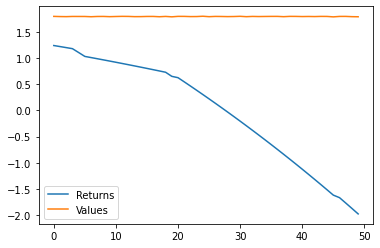

In [ ]:
log = logger.stack()
idx = 274 #275
print(log[idx])
print(f'Last reward: {log[idx,1][-1]}')
print(f'Last frame: {log[idx,2][-1]}')
print(f'No. steps: {len(log[idx,0])}')
print(f'Avg. no. steps: {np.mean(list(map(len,log[:,0])))}')
print(f'Avg. Returns: {list(map(np.mean,log[:,3]))}')
print(f'Avg. Values: {list(map(np.mean,log[:,4]))}')

plt.plot(np.arange(len(log[idx,3])),log[idx,3],label='Returns')
plt.plot(np.arange(len(log[idx,4])),log[idx,4],label='Values')
plt.legend()

In [ ]:
sum([
  -2.10680866e+00 ,-2.85807514e+00 ,-3.44942689e+00 ,-3.95328927e+00
  ,-4.39982367e+00 ,-4.80503893e+00 ,-5.17864370e+00 ,-5.52705193e+00
  ,-5.85476351e+00, -6.16507959e+00 ,-6.46050739e+00 ,-6.74300432e+00
  ,-7.01413298e+00 ,-7.27516413e+00, -7.52714825e+00 ,-7.77096605e+00
  ,-8.00736332e+00 ,-8.23697853e+00])

-103.33326625999999

In [ ]:
rewards = torch.concat((torch.ones(54)*10,torch.ones(45)*-10,torch.tensor([500])),0)
n = rewards.size()[0]
returns = torch.tensor([],device=DEVICE)
rewards = torch.tensor(rewards.flip(0),dtype=torch.float32,device=DEVICE)
discounted_sum = torch.tensor(0.0,device=DEVICE)
discounted_sum_shape = discounted_sum.size()
for i in range(n):
  reward = rewards[i]
  discounted_sum = reward + gamma * discounted_sum
  returns = torch.cat((returns, torch.unsqueeze(discounted_sum,0)))
  discounted_sum.view(discounted_sum_shape)
returns = returns.flip(0)
print(returns)

tensor([392.2618, 386.1230, 379.9223, 373.6588, 367.3322, 360.9416, 354.4864,
        347.9661, 341.3799, 334.7271, 328.0072, 321.2194, 314.3630, 307.4373,
        300.4418, 293.3755, 286.2379, 279.0282, 271.7456, 264.3895, 256.9591,
        249.4536, 241.8723, 234.2145, 226.4793, 218.6659, 210.7737, 202.8017,
        194.7492, 186.6153, 178.3993, 170.1003, 161.7175, 153.2500, 144.6970,
        136.0576, 127.3309, 118.5160, 109.6121, 100.6183,  91.5337,  82.3572,
         73.0881,  63.7254,  54.2680,  44.7152,  35.0658,  25.3190,  15.4738,
          5.5291,  -4.5161, -14.6627, -24.9118, -35.2645, -45.7217, -36.0825,
        -26.3460, -16.5111,  -6.5769,   3.4577,  13.5936,  23.8320,  34.1737,
         44.6199,  55.1716,  65.8299,  76.5959,  87.4706,  98.4551, 109.5506,
        120.7582, 132.0790, 143.5141, 155.0648, 166.7321, 178.5173, 190.4215,
        202.4459, 214.5919, 226.8605, 239.2530, 251.7707, 264.4148, 277.1867,
        290.0876, 303.1187, 316.2816, 329.5773, 343.0074, 356.57

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


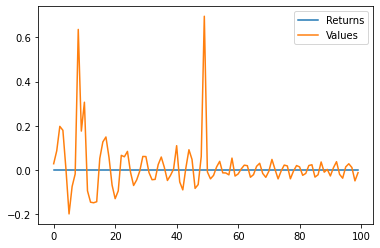

In [ ]:
offset = -100
plt.plot(np.arange(len(log[offset:,3])),list(map(np.mean,log[offset:,3])),label='Returns')
plt.plot(np.arange(len(log[offset:,4])),list(map(np.mean,log[offset:,4])),label='Values')
plt.legend()

0.0
561.8323353293413


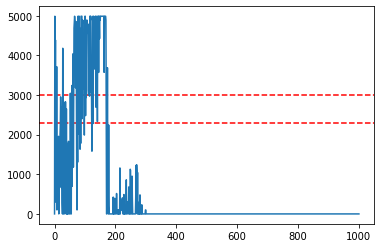

In [ ]:
plt.axhline(y=3000, color='r', linestyle='--')
plt.axhline(y=2300, color='r', linestyle='--')
plt.plot(np.arange(len(FRAMES)),FRAMES)
print(np.median(FRAMES))
print(np.mean(FRAMES))

3300.0
3180.2359550561796


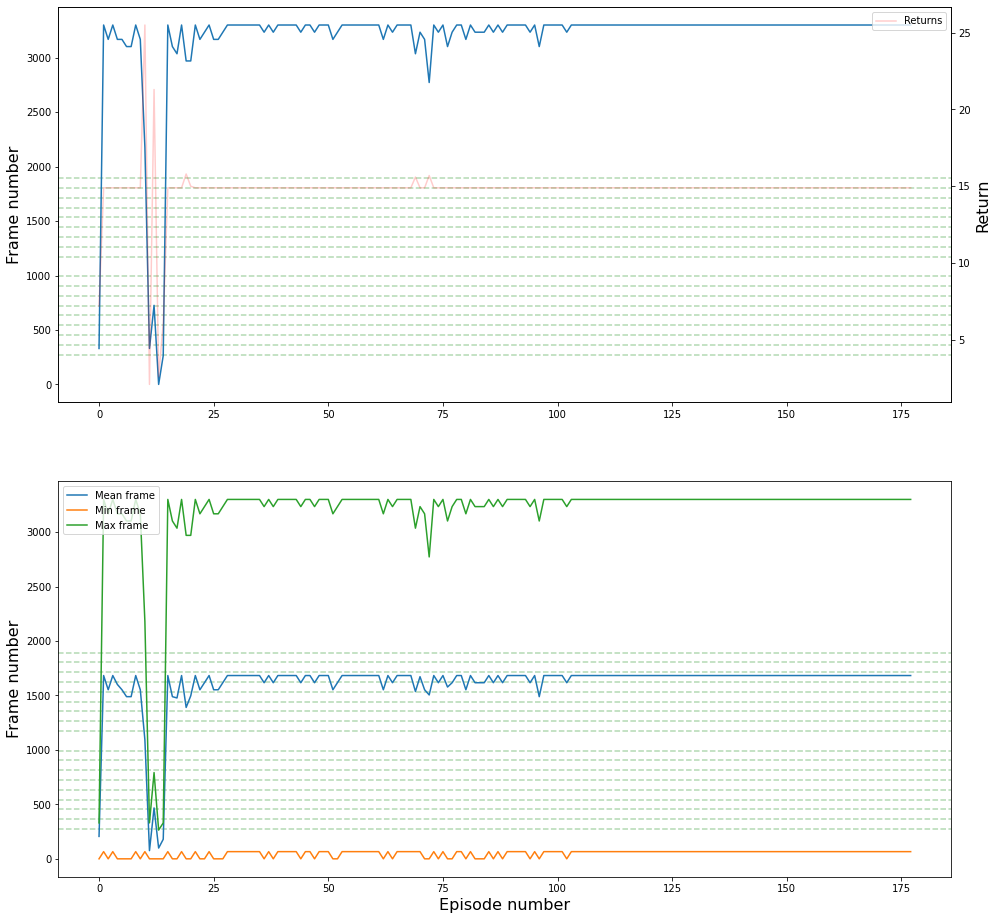

In [ ]:
start = 0
end = 350
thresh = 1083 #idx 4: 2681
log = logger.stack()

fig,ax = plt.subplots(2,1,figsize=(16,16))
# plt.axhline(y=2481, color='r', linestyle='--')
# plt.axhline(y=2881, color='r', linestyle='--')
# plt.axhline(y=3281, color='g', linestyle='--')
# plt.axhline(y=2081, color='g', linestyle='--')
# plt.axhline(y=3881, color='b', linestyle='--')
# plt.axhline(y=1481, color='b', linestyle='--')

for line in np.arange(90,900,90):
  ax[0].axhline(y=thresh-line, color='g', linestyle='--',alpha=0.3)
  ax[0].axhline(y=thresh+line, color='g', linestyle='--',alpha=0.3)
  ax[1].axhline(y=thresh-line, color='g', linestyle='--',alpha=0.3)
  ax[1].axhline(y=thresh+line, color='g', linestyle='--',alpha=0.3)

ax[0].plot(np.arange(len(FRAMES[start:end])),FRAMES[start:end],label='Frames')
ax[0].set_ylabel('Frame number',size=16)
ax2 = ax[0].twinx()
ax2.plot(np.arange(len(REWARDS[start:end])),REWARDS[start:end],color='r',alpha=0.2,label='Returns')
ax2.set_ylabel('Return',size=16)
plt.legend()

ax[1].plot(np.arange(len(log[start:end,2])),list(map(np.mean,log[start:end,2])),label='Mean frame')
ax[1].plot(np.arange(len(log[start:end,2])),list(map(np.min,log[start:end,2])),label='Min frame')
ax[1].plot(np.arange(len(log[start:end,2])),list(map(np.max,log[start:end,2])),label='Max frame')
ax[1].set_ylabel('Frame number',size=16)
ax[1].legend()

ax[1].set_xlabel('Episode number',size=16)

print(np.median(FRAMES))
print(np.mean(FRAMES))

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: nn.Module, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  env = gym.make("CartPole-v0").env
  state = torch.tensor(env.reset(), dtype=torch.float32)
  for i in range(1, max_steps + 1):
    state = torch.unsqueeze(state, 0)
    action_probs, _ = model(state)
    action = torch.argmax(torch.squeeze(action_probs))

    state, _, done, _ = env.step(int(action))
    state = torch.tensor(state, dtype=torch.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      print(i)
      break
  
  return images


# Save GIF image
images = render_episode(env, model, 1800)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

ModuleNotFoundError: ignored


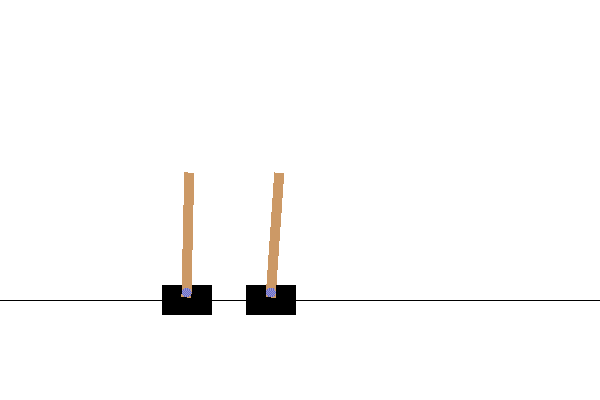

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

In [ ]:
import numpy as np
import h5py
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = h5py.File('/content/drive/MyDrive/Thesis/Data/Idx_4_skip_10.h5','r')
training_imgs = np.array(file.get('data'))
file.close()
training_imgs = np.moveaxis(training_imgs,[0,2,3,1],[0,1,2,3])
print(f'Training imgs: {training_imgs.shape}')

training_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Labels_Idx_4_skip_10.csv',delimiter=',')
training_labels = tf.one_hot(training_labels, 2)
print(f'Training Labels: {training_labels.shape}')

file = h5py.File('/content/drive/MyDrive/Thesis/Data/Idx_1_skip_3.h5','r')
val_imgs = np.array(file.get('data'))
file.close()
val_imgs = np.moveaxis(val_imgs,[0,2,3,1],[0,1,2,3])
print(f'Validation imgs: {val_imgs.shape}')

val_labels = np.genfromtxt('/content/drive/MyDrive/Thesis/Data/Labels_Idx_1_skip_3.csv',delimiter=',')
val_labels = tf.one_hot(val_labels, 2)
print(f'Validation Labels: {val_labels.shape}')

Training imgs: (499, 128, 165, 3)
Training Labels: (499, 2)
Validation imgs: (496, 128, 165, 3)
Validation Labels: (496, 2)


In [ ]:
res = ResNet50( include_top=False,
                weights=None,
                input_tensor=None,
                input_shape=(128,165,3),
                pooling='avg'
                #classes=2,
                #classifier_activation='softmax'
)
actor = layers.Dense(units='3',activation='relu')(res.output)
critic = layers.Dense(units='1',activation='relu')(res.output)

model = tf.keras.Model(inputs=res.input, outputs=[actor,critic])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 128, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 171, 3)  0           ['input_26[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 83, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 83, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
model.predict(np.expand_dims(training_imgs[0],0))

[array([[0., 0., 0.]], dtype=float32), array([[0.]], dtype=float32)]

In [ ]:
model_input_size = (128, 165)

model = ResNet50( 
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(128,165,3),
    pooling='avg',
    classes=2,
    classifier_activation='softmax'
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

print(model.summary())

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 165, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 171, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 83, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 83, 64)   256         ['conv1_conv[0][0]']     

In [ ]:
EPOCHS = 100
BATCH_SIZE = 50
TRAINSET_SIZE = 499
VALSET_SIZE = 496

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history = model.fit(training_imgs, 
                          training_labels, 
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          validation_data=(val_imgs, val_labels))

Epoch 1/100
10/10 [==============================] - 41s 2s/step - loss: 0.7464 - categorical_accuracy: 0.5932 - val_loss: 1.0948 - val_categorical_accuracy: 0.2722
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.5084 - categorical_accuracy: 0.7635 - val_loss: 0.7540 - val_categorical_accuracy: 0.2722
Epoch 3/100
10/10 [==============================] - 17s 2s/step - loss: 0.4665 - categorical_accuracy: 0.7936 - val_loss: 0.8529 - val_categorical_accuracy: 0.2681
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 0.4490 - categorical_accuracy: 0.8136 - val_loss: 1.0348 - val_categorical_accuracy: 0.2722
Epoch 5/100
10/10 [==============================] - 17s 2s/step - loss: 0.4483 - categorical_accuracy: 0.8176 - val_loss: 1.1579 - val_categorical_accuracy: 0.2722
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 0.4189 - categorical_accuracy: 0.8236 - val_loss: 1.2655 - val_categorical_accuracy: 0.2722
Epoch 7/10

KeyboardInterrupt: ignored